In [1]:
# We explore the effect of nonlinear activations on the convexity of GLM.

In [2]:
import sys
sys.path.append('../stimulus_core/')
sys.path.append('../models_core/')
sys.path.append('../helper/')

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import tensorflow as tf


import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import importlib

import lplc2_models as lplc2
import helper_functions as hpfn

## Loss landscape of the looming models

In [4]:
M = 1

# some hyperparameters 
args = {}
args['use_ln'] = True # whether train an ln model without individual inhibitory units
args['restrict_nonneg_weight'] = False # whether restrict the weights to be nonnegative
args['glm'] = False # whether reduce the model to a glm, need args['use_ln'] to be true and args['restrict_nonneg_weight'] false
args['rectified_inhibition'] = False # whether rectify the inhibition or not
args['M'] = M # total number of model units
args['save_folder'] = 'multi_lplc2_training_D5_exp/' # folder that stores the trained results
args['data_path'] = '/Volumes/Baohua/data_on_hd/loom/multi_lplc2_D5_L4_exp/' # path for the training and testing dataset
args['set_number'] = np.int(1000+args['M']) # indicate which dataset to be used for training
args['N_epochs'] = 2000 # number of training epochs
args['rotational_fraction'] = 1.0 # fraction of rotational data that is used in training and testing
args['K'] = 12 # size of one of the dimensions of the square receptive field matrix
args['L'] = 4 # resoluton of of each element in the args['K'] by args['K'] receptive field.
args['lr'] = 1e-3 # learning rate
args['restrict_nonpos_intercept'] = False # whether restrict the intercepts to be nonpositive 
args['rotation_symmetry'] = True # whether impose 90-deg rotation symmetry in the weights
args['flip_symmetry'] = True # whether impose left-right or up-down symmetry in the weights
args['train_a'] = False # whether train the slope a inside the probabilistic model (the sigmoid function)
args['report_num'] = 400 # how many steps to report the training process once
args['max_response'] = False # whether use maximum response or the averaged one over the whole trajectory
args['temporal_filter'] = False # whether use the temporal filter to convolve the model response
args['n'] = 1 # order of temporal filters, which is not used in our current model
args['dt'] = 0.01 # time resolution of the temporal filters
args['tau'] = 2.0 # timescale of the temporal filter, 0->1s, 1->368ms, 2-> 135ms, 3->50 ms,  4->18ms
args['learn_tau'] = False # whether train the timescale args['tau'] of the temporal filter
args['activation'] = 0 # activation function used in the model, 0 is ReLU, 1 is Leaky ReLU, 2 is ELU, 3 is tanh
args['leaky_relu_constant'] = 0.02 # the coefficient for the negative part of the leaky ReLU
args['square_activation'] = False # whether square the response of each model unit
args['save_intermediate_weights'] = False # whether save intermediate weights
args['save_steps'] = np.int(args['N_epochs']/10) # how many training epochs to save the intermediate weights once
args['use_step_weight'] = False # whether use step weights to weight the response or not
args['l1_regu_we'] = 0. # L1 regularization strength for excitatory weights
args['l1_regu_wi'] = 0. # L1 regularization strength for inhibitory weights
args['l1_regu_a'] = 0. # L1 regularization strength for slope a if args['train_a'] is set to be true
args['l2_regu_we'] = 1e-4 # L2 regularization strength for excitatory weights
args['l2_regu_wi'] = 1e-4 # L2 regularization strength for inhibitory weights
args['l2_regu_a'] = 0. # L2 regularization strength for slope a if args['train_a'] is set to be true
args['NNs'] = 10 # number of data samples that are combined into a list to reduce the amount of files
args['S'] = 5 # number of lists of data samples in one batch, and thus batch size is args['NNs'] * args['S']

# Regularization
l1_l2_regu_we = tf.contrib.layers.l1_l2_regularizer(scale_l1=args["l1_regu_we"], scale_l2=args["l2_regu_we"], scope=None)
l1_l2_regu_wi = tf.contrib.layers.l1_l2_regularizer(scale_l1=args["l1_regu_wi"], scale_l2=args["l2_regu_wi"], scope=None)
l1_l2_regu_a = tf.contrib.layers.l1_l2_regularizer(scale_l1=args["l1_regu_a"], scale_l2=args["l2_regu_a"], scope=None)

if M in [1, 2, 4]:
    args['S'] = np.int(args['S'] * 8 / M)

# Check if need process the training and testing data
data_path = args['data_path']
set_number = args['set_number']
condition1 = os.path.exists(data_path + 'set_{}/training/'.format(set_number)+'train_flow_files.npy')
condition2 = os.path.exists(data_path + 'set_{}/training/'.format(set_number)+'train_flow_snapshots.npy')
if not (condition1 and condition2):
    # generate the training and testing samples, whole trajectories
    train_flow_files, _, train_labels, train_distances, \
    test_flow_files, _, test_labels, test_distances \
        = hpfn.generate_train_test_file_paths(args)  
    # generate the training samples, single frames (for each trajectory, one frame is randomly selected)
    hpfn.generate_train_data(args)

# Load data
train_flow_files = np.load(data_path + 'set_{}/training/'.format(set_number)+'train_flow_files.npy', \
                           allow_pickle=True)
train_intensity_files = np.load(data_path + 'set_{}/training/'.format(set_number)+'train_intensity_files.npy', \
                                allow_pickle=True)
train_labels = np.load(data_path + 'set_{}/training/'.format(set_number)+'train_labels.npy', \
                       allow_pickle=True)
train_distances = np.load(data_path + 'set_{}/training/'.format(set_number)+'train_distances.npy', \
                          allow_pickle=True)
train_flow_snapshots = np.load(data_path + 'set_{}/training/'.format(set_number)+'train_flow_snapshots.npy', \
                               allow_pickle=True)
train_labels_snapshots = np.load(data_path + 'set_{}/training/'.format(set_number)+'train_labels_snapshots.npy', \
                                 allow_pickle=True)

args['train_distances'] = train_distances # distances for the trajectories of the training samples

flow_shape = train_flow_snapshots.shape
label_shape = train_labels_snapshots.shape
print(flow_shape)
print(label_shape)

train_flow_snapshots_r = train_flow_snapshots.reshape((1, flow_shape[0]*flow_shape[2], M, 144, 4))
train_labels_snapshots_r = train_labels_snapshots.reshape((1, label_shape[0]*label_shape[2]))
print(train_flow_snapshots_r.shape)
print(train_labels_snapshots_r.shape)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Scale of 0 disables regularizer.
(80, 1, 400, 1, 144, 4)
(80, 1, 400)
(1, 32000, 1, 144, 4)
(1, 32000)


In [6]:
importlib.reload(hpfn)

figure_path = '/Volumes/Baohua/research/loom_detection/results/revision/'
data_path = figure_path + 'model_clustering_ln_relu_correct_initialization/clusterings/'
model_folders = np.load(data_path+'model_folders_M{}.npy'.format(M), allow_pickle=True)

parameters_in_both = np.zeros((3, 147), dtype=np.float32)

for in_or_out in [0, 1, 2]:
    model_path = model_folders[in_or_out][0] + '/'
    print(in_or_out, model_path)
    a = np.load(model_path + "trained_a.npy")
    b = np.load(model_path + "trained_b.npy")
    print(in_or_out, b)
    intercept_e = np.load(model_path + "trained_intercept_e.npy")
    weights_e = np.load(model_path + "trained_weights_e.npy")
    intercept_i = np.load(model_path + "trained_intercept_i.npy")
    weights_i = np.load(model_path + "trained_weights_i.npy")

    parameters_in_both[in_or_out, 0] = b
    parameters_in_both[in_or_out, 1] = intercept_e
    parameters_in_both[in_or_out, 2:74] = weights_e[:72, 0]
    parameters_in_both[in_or_out, 74] = intercept_i
    parameters_in_both[in_or_out, 75:147]= weights_i[:72, 0]

# if in_or_out == 0:
#     gradient_all_outward_tf.append(grad_res)
# else:
#     gradient_all_inward_tf.append(grad_res)

# if in_or_out == 0: 
#     filename = figure_path + 'gradient_all_outward_tf'
#     np.save(filename, gradient_all_outward_tf)
# else:      
#     filename = figure_path + 'gradient_all_inward_tf'
#     np.save(filename, gradient_all_inward_tf)


0 /Volumes/Baohua/research_large_files/loom_detection/multi_lplc2_training_D5_exp_ln_relu_correct_initialization/M_1/lr_0.001/regu_0.0001/seed_100_20211205130302/
0 [-1.12534]
1 /Volumes/Baohua/research_large_files/loom_detection/multi_lplc2_training_D5_exp_ln_relu_correct_initialization/M_1/lr_0.001/regu_0.0001/seed_102_20211206160206/
1 [-2.5420825]
2 /Volumes/Baohua/research_large_files/loom_detection/multi_lplc2_training_D5_exp_ln_relu_correct_initialization/M_1/lr_0.001/regu_0.0001/seed_101_20211206160205/
2 [-1.0974228]


In [62]:
importlib.reload(hpfn)

parameters_in_both_diff = parameters_in_both[1] - parameters_in_both[0]
sampling_vec_along = np.linspace(-1, 2, 300)

loss_res_along = []
for ii in range(len(sampling_vec_along)):
    parameters_in = parameters_in_both[0] + sampling_vec_along[ii] * parameters_in_both_diff
    loss_res = \
        hpfn.get_gradient_hessian(args, train_flow_snapshots_r, train_labels_snapshots_r, parameters_in)
    loss_res_along.append(loss_res)
    print(ii, loss_res)
    
# np.save('../results/loss_res_along', loss_res_along)

INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0 1.153857
INFO:tensorflow:Scale of 0 disables regularizer.
1 1.1435926
INFO:tensorflow:Scale of 0 disables regularizer.
2 1.1333985
INFO:tensorflow:Scale of 0 disables regularizer.
3 1.12326
INFO:tensorflow:Scale of 0 disables regularizer.
4 1.1131828
INFO:tensorflow:Scale of 0 disables regularizer.
5 1.1031861
INFO:tensorflow:Scale of 0 disables regularizer.
6 1.093246
INFO:tensorflow:Scale of 0 disables regularizer.
7 1.0833737
INFO:tensorflow:Scale of 0 disables regularizer.
8 1.0735688
INFO:tensorflow:Scale of 0 disables regularizer.
9 1.0638164
INFO:tensorflow:Scale of 0 disables regularizer.
10 1.0541481
INFO:tensorflow:Scale of 0 disables regularizer.
11 1.0445457
INFO:tensorflow:Scale of 0 disables regularizer.
12 1.0350074
INFO:tensorflow:Scale of 0 disables regularizer.
13 1.0255371
INFO:tensorflow:Scale of 0 disables regularizer.
14 

126 0.5766936
INFO:tensorflow:Scale of 0 disables regularizer.
127 0.57768375
INFO:tensorflow:Scale of 0 disables regularizer.
128 0.57871616
INFO:tensorflow:Scale of 0 disables regularizer.
129 0.579779
INFO:tensorflow:Scale of 0 disables regularizer.
130 0.580878
INFO:tensorflow:Scale of 0 disables regularizer.
131 0.58200717
INFO:tensorflow:Scale of 0 disables regularizer.
132 0.58316797
INFO:tensorflow:Scale of 0 disables regularizer.
133 0.58436596
INFO:tensorflow:Scale of 0 disables regularizer.
134 0.5855948
INFO:tensorflow:Scale of 0 disables regularizer.
135 0.58685976
INFO:tensorflow:Scale of 0 disables regularizer.
136 0.58815247
INFO:tensorflow:Scale of 0 disables regularizer.
137 0.5894761
INFO:tensorflow:Scale of 0 disables regularizer.
138 0.5908362
INFO:tensorflow:Scale of 0 disables regularizer.
139 0.5922229
INFO:tensorflow:Scale of 0 disables regularizer.
140 0.59364027
INFO:tensorflow:Scale of 0 disables regularizer.
141 0.5950937
INFO:tensorflow:Scale of 0 disables

256 0.65385234
INFO:tensorflow:Scale of 0 disables regularizer.
257 0.6595655
INFO:tensorflow:Scale of 0 disables regularizer.
258 0.6653633
INFO:tensorflow:Scale of 0 disables regularizer.
259 0.6712428
INFO:tensorflow:Scale of 0 disables regularizer.
260 0.6772054
INFO:tensorflow:Scale of 0 disables regularizer.
261 0.6832442
INFO:tensorflow:Scale of 0 disables regularizer.
262 0.6893679
INFO:tensorflow:Scale of 0 disables regularizer.
263 0.69557136
INFO:tensorflow:Scale of 0 disables regularizer.
264 0.7018463
INFO:tensorflow:Scale of 0 disables regularizer.
265 0.70820147
INFO:tensorflow:Scale of 0 disables regularizer.
266 0.71463424
INFO:tensorflow:Scale of 0 disables regularizer.
267 0.721141
INFO:tensorflow:Scale of 0 disables regularizer.
268 0.7277192
INFO:tensorflow:Scale of 0 disables regularizer.
269 0.7343668
INFO:tensorflow:Scale of 0 disables regularizer.
270 0.74109435
INFO:tensorflow:Scale of 0 disables regularizer.
271 0.7478887
INFO:tensorflow:Scale of 0 disables r

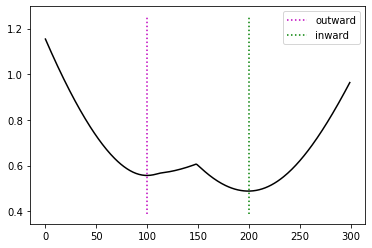

In [72]:
fig = plt.figure()
plt.plot(loss_res_along, 'k')
h1 = plt.plot([100, 100], [min(loss_res_along)-0.1, max(loss_res_along)+0.1], 'm:')
h2 = plt.plot([200, 200], [min(loss_res_along)-0.1, max(loss_res_along)+0.1], 'g:')
plt.legend([h1[0], h2[0]], ['outward', 'inward'])

filename = f'../results/loss_landscape_along.pdf'
fig.savefig(filename, bbox_inches='tight')

plt.show()

Now, printing figure for parameter_id 0.
Now, printing figure for parameter_id 1.
Now, printing figure for parameter_id 2.
Now, printing figure for parameter_id 3.
Now, printing figure for parameter_id 4.
Now, printing figure for parameter_id 5.
Now, printing figure for parameter_id 6.
Now, printing figure for parameter_id 7.
Now, printing figure for parameter_id 8.
Now, printing figure for parameter_id 9.
Now, printing figure for parameter_id 10.
Now, printing figure for parameter_id 11.
Now, printing figure for parameter_id 12.
Now, printing figure for parameter_id 13.
Now, printing figure for parameter_id 14.
Now, printing figure for parameter_id 15.
Now, printing figure for parameter_id 16.
Now, printing figure for parameter_id 17.
Now, printing figure for parameter_id 18.
Now, printing figure for parameter_id 19.
Now, printing figure for parameter_id 20.
Now, printing figure for parameter_id 21.
Now, printing figure for parameter_id 22.
Now, printing figure for parameter_id 23.
No

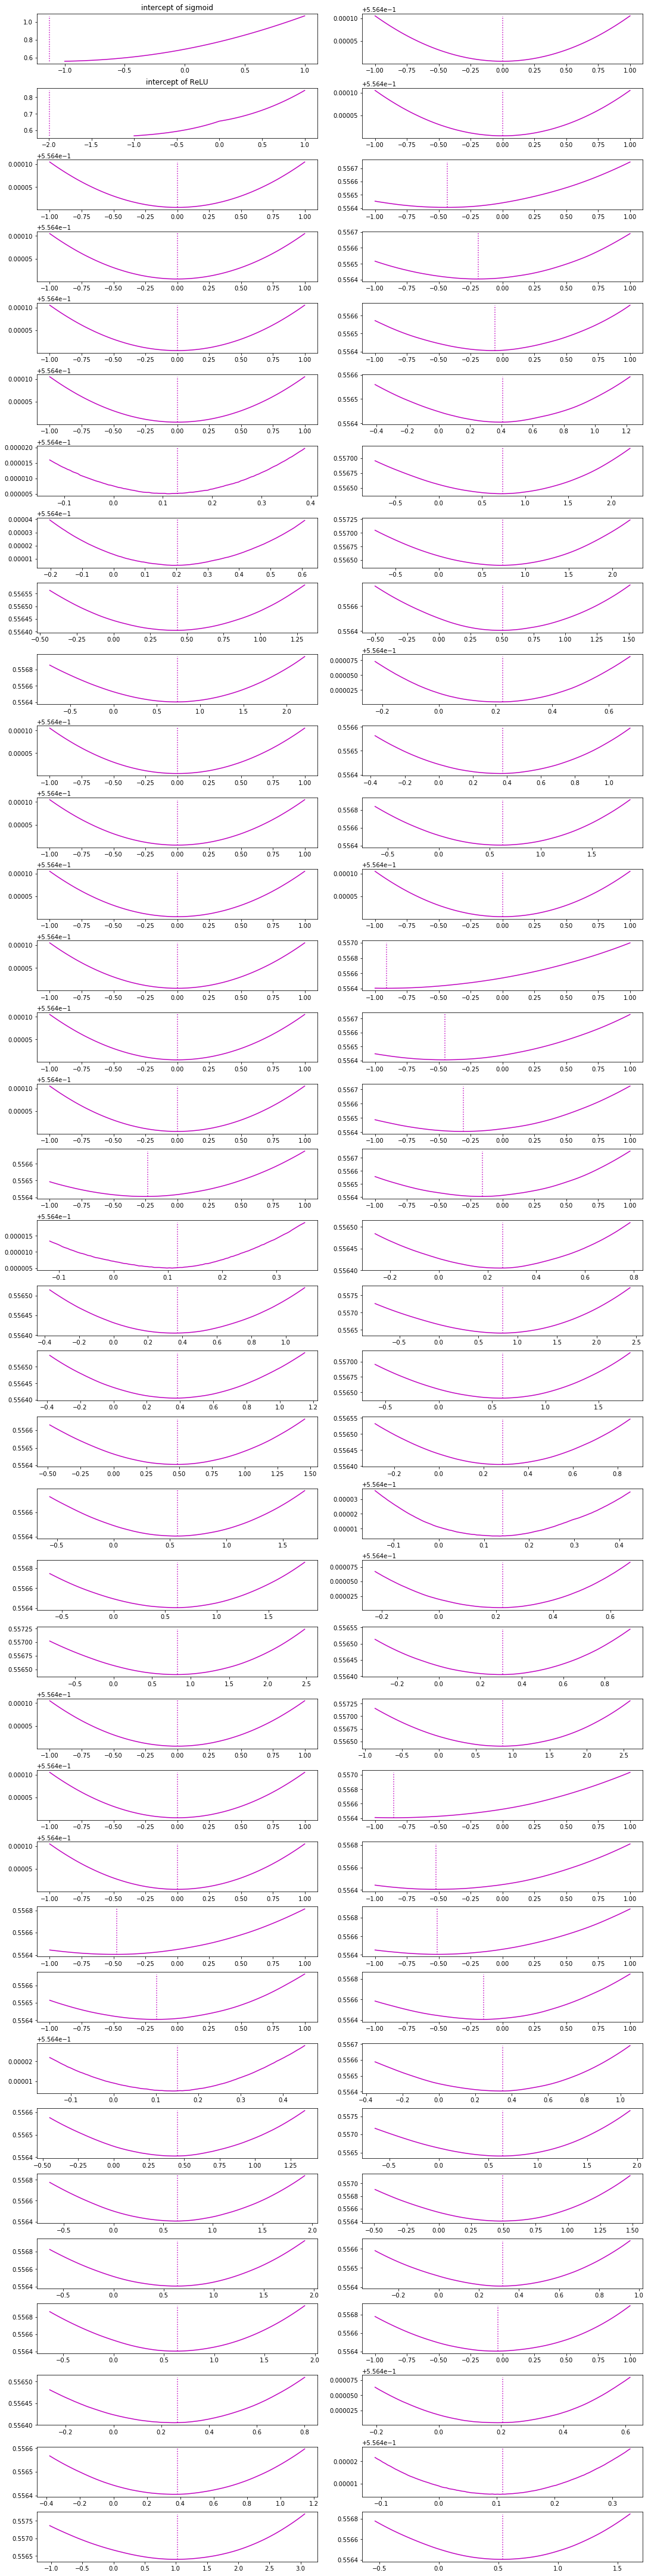

Now, printing figure for parameter_id 0.
Now, printing figure for parameter_id 1.
Now, printing figure for parameter_id 2.
Now, printing figure for parameter_id 3.
Now, printing figure for parameter_id 4.
Now, printing figure for parameter_id 5.
Now, printing figure for parameter_id 6.
Now, printing figure for parameter_id 7.
Now, printing figure for parameter_id 8.
Now, printing figure for parameter_id 9.
Now, printing figure for parameter_id 10.
Now, printing figure for parameter_id 11.
Now, printing figure for parameter_id 12.
Now, printing figure for parameter_id 13.
Now, printing figure for parameter_id 14.
Now, printing figure for parameter_id 15.
Now, printing figure for parameter_id 16.
Now, printing figure for parameter_id 17.
Now, printing figure for parameter_id 18.
Now, printing figure for parameter_id 19.
Now, printing figure for parameter_id 20.
Now, printing figure for parameter_id 21.
Now, printing figure for parameter_id 22.
Now, printing figure for parameter_id 23.
No

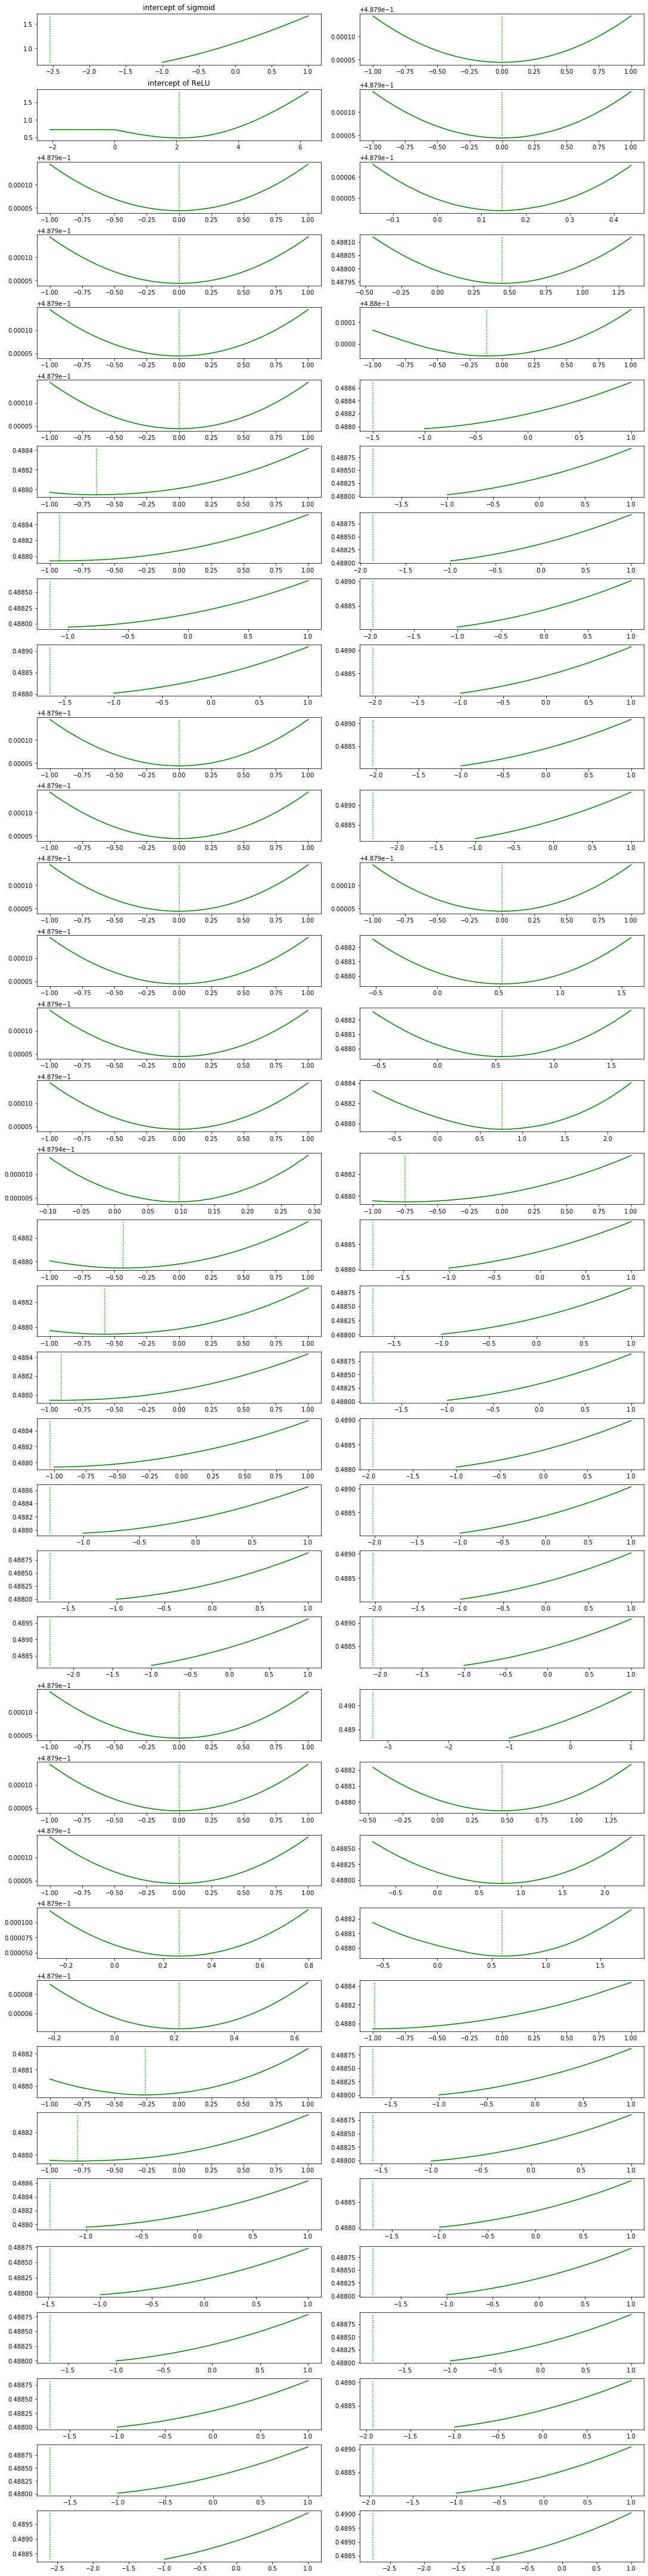

Now, printing figure for parameter_id 0.
Now, printing figure for parameter_id 1.
Now, printing figure for parameter_id 2.
Now, printing figure for parameter_id 3.
Now, printing figure for parameter_id 4.
Now, printing figure for parameter_id 5.
Now, printing figure for parameter_id 6.
Now, printing figure for parameter_id 7.
Now, printing figure for parameter_id 8.
Now, printing figure for parameter_id 9.
Now, printing figure for parameter_id 10.
Now, printing figure for parameter_id 11.
Now, printing figure for parameter_id 12.
Now, printing figure for parameter_id 13.
Now, printing figure for parameter_id 14.
Now, printing figure for parameter_id 15.
Now, printing figure for parameter_id 16.
Now, printing figure for parameter_id 17.
Now, printing figure for parameter_id 18.
Now, printing figure for parameter_id 19.
Now, printing figure for parameter_id 20.
Now, printing figure for parameter_id 21.
Now, printing figure for parameter_id 22.
Now, printing figure for parameter_id 23.
No

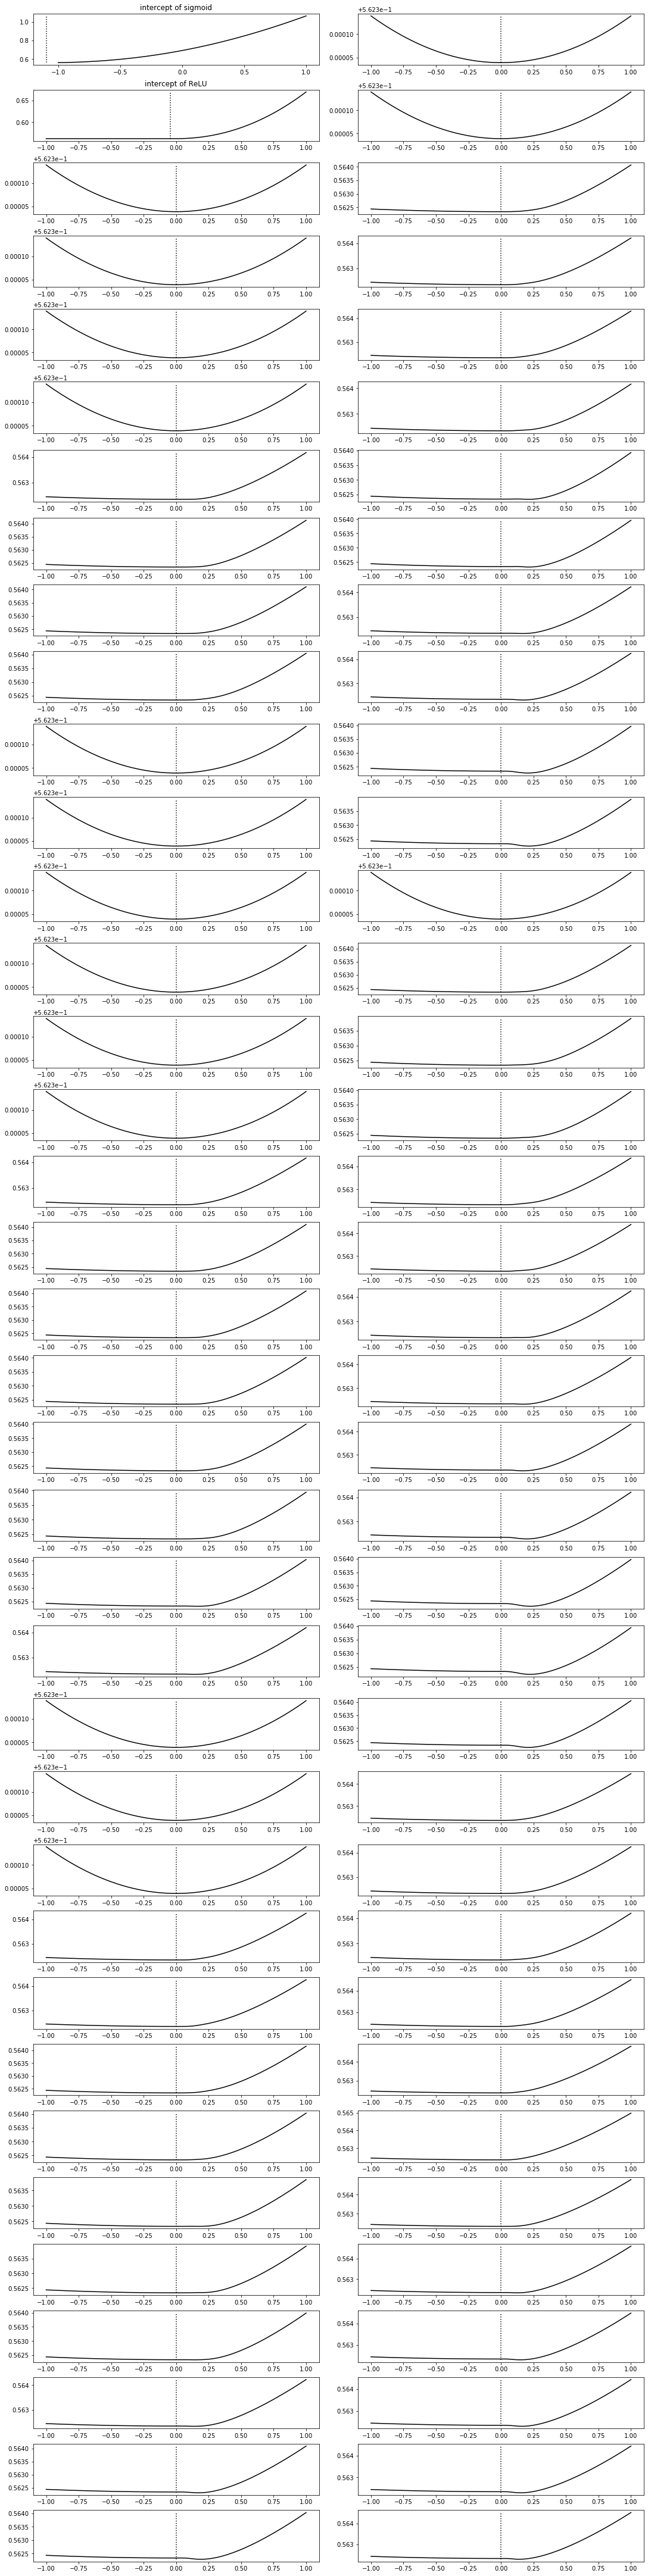

In [8]:
res_folder = '/Volumes/Baohua/research_large_files/loom_detection/loss_landscape_ln_small_range_with_zero_solution/'

for in_or_out in [0, 1, 2]:
    fig = plt.figure(figsize = (15, 60), constrained_layout=True)
    gs0 = gridspec.GridSpec(ncols=2, nrows=37, figure=fig)
    for parameter_id in range(74):
        row_n = parameter_id % 37
        col_n = int(parameter_id / 37)
        loss_landscape = np.load(res_folder + f'loss_landscape_{in_or_out}_{parameter_id}.npy')
        if in_or_out == 0:
            ax = fig.add_subplot(gs0[row_n, col_n])
            ax.plot(loss_landscape[0], loss_landscape[1], 'm')
            ax.plot([parameters_in_both[0][parameter_id], parameters_in_both[0][parameter_id]], \
                   [loss_landscape[1].min(), loss_landscape[1].max()], 'm:')
        elif in_or_out == 1:
            ax = fig.add_subplot(gs0[row_n, col_n])
            ax.plot(loss_landscape[0], loss_landscape[1], 'g')
            ax.plot([parameters_in_both[1][parameter_id], parameters_in_both[1][parameter_id]], \
                   [loss_landscape[1].min(), loss_landscape[1].max()], 'g:')
        elif in_or_out == 2:
            ax = fig.add_subplot(gs0[row_n, col_n])
            ax.plot(loss_landscape[0], loss_landscape[1], 'k')
            ax.plot([parameters_in_both[2][parameter_id], parameters_in_both[2][parameter_id]], \
                   [loss_landscape[1].min(), loss_landscape[1].max()], 'k:')
        if parameter_id == 0:
            ax.set_title('intercept of sigmoid')
        elif parameter_id == 1:
            ax.set_title('intercept of ReLU')
        print(f'Now, printing figure for parameter_id {parameter_id}.')

    filename = f'../results/loss_landscape_ln_with_zero_solutions_in_or_out{in_or_out}.pdf'
    fig.savefig(filename, bbox_inches='tight')

    plt.show()

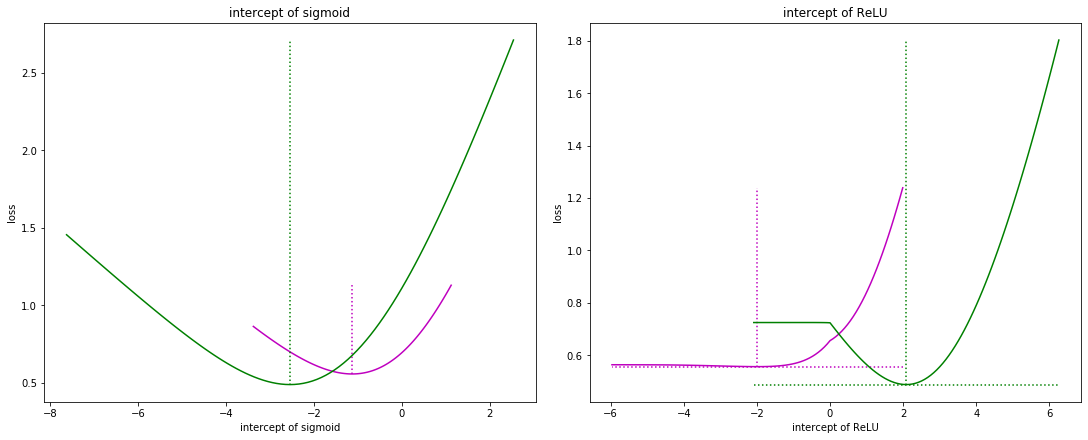

In [17]:
res_folder = '/Volumes/Baohua/research_large_files/loom_detection/loss_landscape_ln_small_range/'

fig = plt.figure(figsize = (15, 6), constrained_layout=True)
gs0 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax = fig.add_subplot(gs0[0, 0])
parameter_id = 0
for in_or_out in [0, 1]:
    loss_landscape = np.load(res_folder + f'loss_landscape_{in_or_out}_{parameter_id}.npy')
    if in_or_out == 0:
        ax.plot(loss_landscape[0], loss_landscape[1], 'm')
        ax.plot([parameters_in_both[0][parameter_id], parameters_in_both[0][parameter_id]], \
               [loss_landscape[1].min(), loss_landscape[1].max()], 'm:')
    else:
        ax.plot(loss_landscape[0], loss_landscape[1], 'g')
        ax.plot([parameters_in_both[1][parameter_id], parameters_in_both[1][parameter_id]], \
               [loss_landscape[1].min(), loss_landscape[1].max()], 'g:')
ax.set_xlabel('intercept of sigmoid')
ax.set_ylabel('loss')
ax.set_title('intercept of sigmoid')

ax = fig.add_subplot(gs0[0, 1])
parameter_id = 1
for in_or_out in [0, 1]:
    loss_landscape = np.load(res_folder + f'loss_landscape_{in_or_out}_{parameter_id}.npy')
    if in_or_out == 0:
        ax.plot(loss_landscape[0], loss_landscape[1], 'm')
        ax.plot([parameters_in_both[0][parameter_id], parameters_in_both[0][parameter_id]], \
               [loss_landscape[1].min(), loss_landscape[1].max()], 'm:')
        ax.plot([loss_landscape[0][0], loss_landscape[0][-1]], \
               [loss_landscape[1].min(), loss_landscape[1].min()], 'm:')
    else:
        ax.plot(loss_landscape[0], loss_landscape[1], 'g')
        ax.plot([parameters_in_both[1][parameter_id], parameters_in_both[1][parameter_id]], \
               [loss_landscape[1].min(), loss_landscape[1].max()], 'g:')
        ax.plot([loss_landscape[0][0], loss_landscape[0][-1]], \
               [loss_landscape[1].min(), loss_landscape[1].min()], 'g:')
ax.set_xlabel('intercept of ReLU')
ax.set_ylabel('loss')
ax.set_title('intercept of ReLU')

filename = f'../results/loss_landscape_small_range_first_two.pdf'
fig.savefig(filename, bbox_inches='tight')

plt.show()

## Loss landscape of a toy model

Let's first consider the following function:
\begin{align}
y(x) = (x-a)^{2}-(x)_{+}.
\end{align}
The quadratic function is convex, but after subtracting a ReLU $(\cdot)_{+}$, it may not be convex for certain values of $a$. See the following figure.

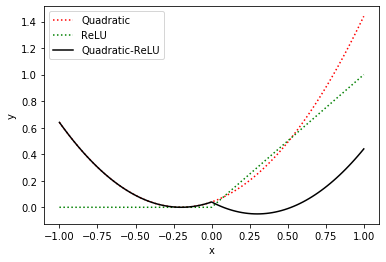

In [3]:
x = np.linspace(-1, 1, 101)
a = -0.2

y1 = (x - a) ** 2
y2 = np.maximum(x, 0)
y3 = y1 - y2

plt.plot(x, y1, 'r:')
plt.plot(x, y2, 'g:')
plt.plot(x, y3, 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Quadratic', 'ReLU', 'Quadratic-ReLU'])

plt.show()

Now let's consider a binary classification task. For postive samples,
\begin{align}
P(y=1) = h_{wb}(x) =  \frac{1}{1+\exp(-(wx+b)_{+})}.
\end{align}
For negative samples,
\begin{align}
P(y=0) = 1-h_{wb}(x) = \frac{\exp(-(wx+b)_{+})}{1+\exp(-(wx+b)_{+})}.
\end{align}
For a data set $\{y_{i}, x_{i}\}$, the cost function is
\begin{align}
L(w, b) &= -\sum_{i}\left[ y_{i}\log(h_{wb}(x_{i})) + (1-y_{i})\log(1-h_{wb}(x_{i})) \right] \\
&= \sum_{i}\left[ \log(1+\exp(-(wx_{i}+b)_{+}))+(1-y_{i})(wx_{i}+b)_{+} \right].
\end{align}
Now, consider a specific data set: $\{(y_{1}=1, x_{1}=2), (y_{2}=1, x_{2}=-2), (y_{3}=0, x_{3}=-1), (y_{4}=0, x_{4}=1)\}$:
\begin{align}
L(w, b) &= \log(1+\exp(-(2w+b)_{+})) \\
&+ \log(1+\exp(-(-2w+b)_{+})) \\
&+ \log(1+\exp(-(-w+b)_{+}))+(-w+b)_{+} \\
&+ \log(1+\exp(-(w+b)_{+}))+(w+b)_{+},
\end{align}
which is coded below (set $b=-0.5$):

In [15]:
def activation_leaky_relu(x, alpha_):
    return np.maximum(x, alpha_*x)

def activation_elu(x, alpha_):
    return np.maximum(x, np.exp(x)-1)


def some_cost_function(w, b, activationf, alpha_):
    L = np.log(1+np.exp(-activationf(1.5*w+b, alpha_))) \
      + np.log(1+np.exp(-activationf(0.5*w+b, alpha_))) \
      + np.log(1+np.exp(-activationf(-1.5*w+b, alpha_))) + activationf(-1.5*w+b, alpha_) \
      + np.log(1+np.exp(-activationf(-0.5*w+b, alpha_))) + activationf(-0.5*w+b, alpha_) 
    
    return L

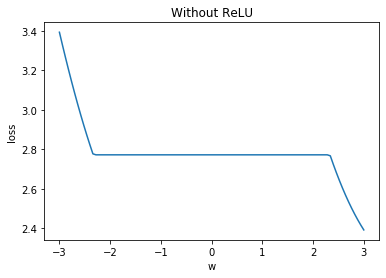

In [19]:
w = np.linspace(-3, 3, 101)
b = -3.5
alpha_ = 0
L = some_cost_function(w, b, activation_leaky_relu, alpha_)

plt.plot(w, L)
plt.xlabel('w')
plt.ylabel('loss')
plt.title('Without ReLU')
plt.show()

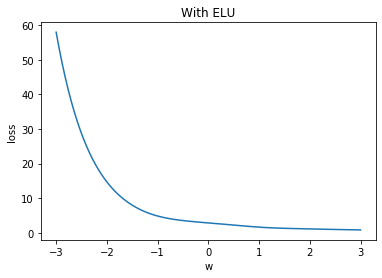

In [20]:
w = np.linspace(-3, 3, 101)
b = -0.5
alpha_ = 1
L = some_cost_function(w, b, activation_elu, alpha_)

plt.plot(w, L)
plt.xlabel('w')
plt.ylabel('loss')
plt.title('With ELU')
plt.show()

2d heatmap, where the black dotted line indicates $b=-0.5$ as in the above.

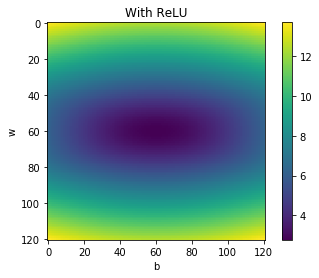

In [7]:
w = np.linspace(-3, 3, 121)
b = np.linspace(-3, 3, 121)
L_2d = np.zeros((121, 121))
alpha_ = 1

for ii in range(121):
    for jj in range(121):
        L_2d[ii, jj] = some_cost_function(w[ii], b[jj], activation_leaky_relu, alpha_)

plt.imshow(L_2d)
# plt.plot([50, 50], [0, 120], 'k:')
# plt.xticks([0, 20, 40, 60, 80, 100, 120], ['-1.2', '-0.8', '-0.4', '0', '0.4', '0.8', '1.2'])
# plt.yticks([0, 20, 40, 60, 80, 100, 120], ['-3', '-2', '-1', '0', '1', '2', '3'])
plt.xlabel('b')
plt.ylabel('w')
plt.title('With ReLU')
plt.colorbar()
plt.show()



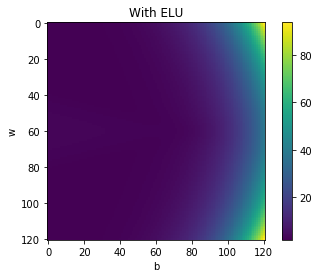

In [8]:
w = np.linspace(-3, 3, 121)
b = np.linspace(-3, 3, 121)
L_2d = np.zeros((121, 121))
alpha_ = 1

for ii in range(121):
    for jj in range(121):
        L_2d[ii, jj] = some_cost_function(w[ii], b[jj], activation_elu, alpha_)

plt.imshow(L_2d)
# plt.plot([50, 50], [0, 120], 'k:')
# plt.xticks([0, 20, 40, 60, 80, 100, 120], ['-1.2', '-0.8', '-0.4', '0', '0.4', '0.8', '1.2'])
# plt.yticks([0, 20, 40, 60, 80, 100, 120], ['-3', '-2', '-1', '0', '1', '2', '3'])
plt.xlabel('b')
plt.ylabel('w')
plt.title('With ELU')
plt.colorbar()
plt.show()



## Train toy Models

In [74]:
class nonlinear_glm_models(nn.Module):
    """
      Nonlinearly activated GLM models
    """
    def __init__(self, nonlinear_activation, negative_slope):
        """
        Args:
        nonlinear_activation: string, nonlinear activation function
        """
        super().__init__()
        self.fc1 = nn.Linear(2, 1, bias=True)
        self.nonlinear_activation = nonlinear_activation
        self.negative_slope = negative_slope
    
    def forward(self, input_data):
        C1_out = self.fc1(input_data)
        
        if self.nonlinear_activation == 'ReLU':
            C1_out = F.relu(C1_out)
        elif self.nonlinear_activation == 'LeakyReLU':
            C1_out = F.leaky_relu(C1_out, negative_slope=self.negative_slope)
        elif self.nonlinear_activation == 'ELU':
            C1_out = F.elu(C1_out)
        elif self.nonlinear_activation == 'Linear':
            C1_out = C1_out
        
        outputs = torch.sigmoid(C1_out)

        return outputs

## Data

In [8]:
# Define the dataset class.
class toy_dataset(Dataset):
    """Toy dataset."""

    def __init__(self, targets, samples, transform=None):
        """
        Args:
            targets: numpy array
            samples: numpy array
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.targets = targets
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        fegure = self.samples[idx]
        target = self.targets[idx]
        sample = {'feature': fegure, 'target': target}

        if self.transform:
            sample = self.transform(sample)

        return sample

    
# Transform functions
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        fegure, target = sample['feature'], sample['target']

        return {'feature': torch.from_numpy(fegure).float(),
                'target': torch.from_numpy(target).float()}
    
    

## Training

In [37]:
# Function to reset the weights before the training
def reset_weights(m):
    '''
      Try resetting model weights to avoid
      weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()
            

# get the loss
def get_loss(transformed_dataset, custom_weight, custom_bias, activationf, batch_size=4, negative_slope=0.02):
    # weight and bias list 
    weight_list = [custom_weight.numpy().copy()[0]]
    bias_list = [custom_bias.numpy().copy()]
    # model
    network_model = nonlinear_glm_models(nonlinear_activation=activationf, negative_slope=negative_slope)
    # loss function
    loss_function = nn.BCELoss()
    # Sample elements with replacement.
    train_subsampler = torch.utils.data.RandomSampler(transformed_dataset, replacement=False)
    # Define data loaders for training
    trainloader = torch.utils.data.DataLoader(
                      transformed_dataset, 
                      batch_size=batch_size, sampler=train_subsampler, num_workers=0)
    # Custom weight and bias
    network_model.fc1.weight = torch.nn.Parameter(custom_weight)
    network_model.fc1.bias = torch.nn.Parameter(custom_bias)
    # Get the loss
    loss_list = []
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader):
        # Get inputs
        inputs, targets = data['feature'], data['target']
        # Perform forward pass
        outputs = network_model(inputs)
        # Compute loss
        loss = loss_function(outputs, targets)
    loss_list.append(loss.item())

    return loss_list
 
    
####### training #######
def train_the_model(transformed_dataset, custom_weight, custom_bias, activationf, num_epochs=1000, batch_size=4, lr=0.01, negative_slope=0.02):
    # weight and bias list 
    weight_list = [custom_weight.numpy().copy()[0]]
    bias_list = [custom_bias.numpy().copy()]

    network_model = nonlinear_glm_models(nonlinear_activation=activationf, negative_slope=negative_slope)

    loss_function = nn.BCELoss()

    # Sample elements with replacement.
    train_subsampler = torch.utils.data.RandomSampler(transformed_dataset, replacement=False)

    # Define data loaders for training
    trainloader = torch.utils.data.DataLoader(
                      transformed_dataset, 
                      batch_size=batch_size, sampler=train_subsampler, num_workers=0)

    # Init the neural network
    network_model.apply(reset_weights)

    # Custom weight and bias
    network_model.fc1.weight = torch.nn.Parameter(custom_weight)
    network_model.fc1.bias = torch.nn.Parameter(custom_bias)

    print(network_model.fc1.weight)

    # Initialize optimizer
    optimizer = torch.optim.Adam(network_model.parameters(), lr=lr, weight_decay=0.01)

    # List to save train losses
    train_loss = []

    # Run the training loop for defined number of epochs
    for epoch in range(num_epochs):
        train_loss_epoch = 0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader):
            # Get inputs
            inputs, targets = data['feature'], data['target']

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            outputs = network_model(inputs)

            # Compute loss
            loss = loss_function(outputs, targets)

            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

            # Print statistics
            train_loss_epoch = train_loss_epoch + loss.item()

        train_loss_epoch = train_loss_epoch / (i+1)
        train_loss.append(train_loss_epoch)
        weight_list.append(network_model.fc1.weight.detach().numpy().copy()[0])
        bias_list.append(network_model.fc1.bias.detach().numpy().copy()[0])

    print(network_model.fc1.weight)
    print(network_model.fc1.bias)
    
    return train_loss, weight_list, bias_list


def line_model(weight, bias):
    w1 = weight[0]
    w2 = weight[1]
    b = bias
    
    if abs(w1) < abs(w2):
        x1 = -1.5
        x2 = 1.5
        y1 = (-w1 * x1 - b) / w2
        y2 = (-w1 * x2 - b) / w2
    else:
        y1 = -1.5
        y2 = 1.5
        x1 = (-w2 * y1 - b) / w1
        x2 = (-w2 * y2 - b) / w1
    
    return (x1, x2), (y1, y2)
    

In [10]:
######## Data #######
train_samples = np.array([[0, 0],
                          [0.2, 0.2],
                          [0, 1],
                          [1, 0]])
train_targets = np.array([[0],
                          [0],
                          [1],
                          [1]])

print(f'The shape of the training samples are {train_samples.shape}.')
print(f'The shape of the training targets are {train_targets.shape}.')

# Get an instance of the dataset class, and feed the loaded data.
transformed_dataset = toy_dataset(targets=train_targets, 
                                  samples=train_samples,
                                  transform=ToTensor())

The shape of the training samples are (4, 2).
The shape of the training targets are (4, 1).


## ReLU

Custom weights 1
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[ 1., -1.]], requires_grad=True)
Parameter containing:
tensor([[ 2.3297, -0.6642]], requires_grad=True)
Parameter containing:
tensor([-0.3327], requires_grad=True)

Custom weights 2
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[-1.,  1.]], requires_grad=True)
Parameter containing:
tensor([[-0.6642,  2.3297]], requires_grad=True)
Parameter containing:
tensor([-0.3327], requires_grad=True)

Custom weights 3
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[1., 1.]], requires_grad=True)
Parameter containing:
tensor([[2.5121, 2.5121]], requires_grad=True)
Parameter containing:
tensor([-1.0022], requires_grad=True)


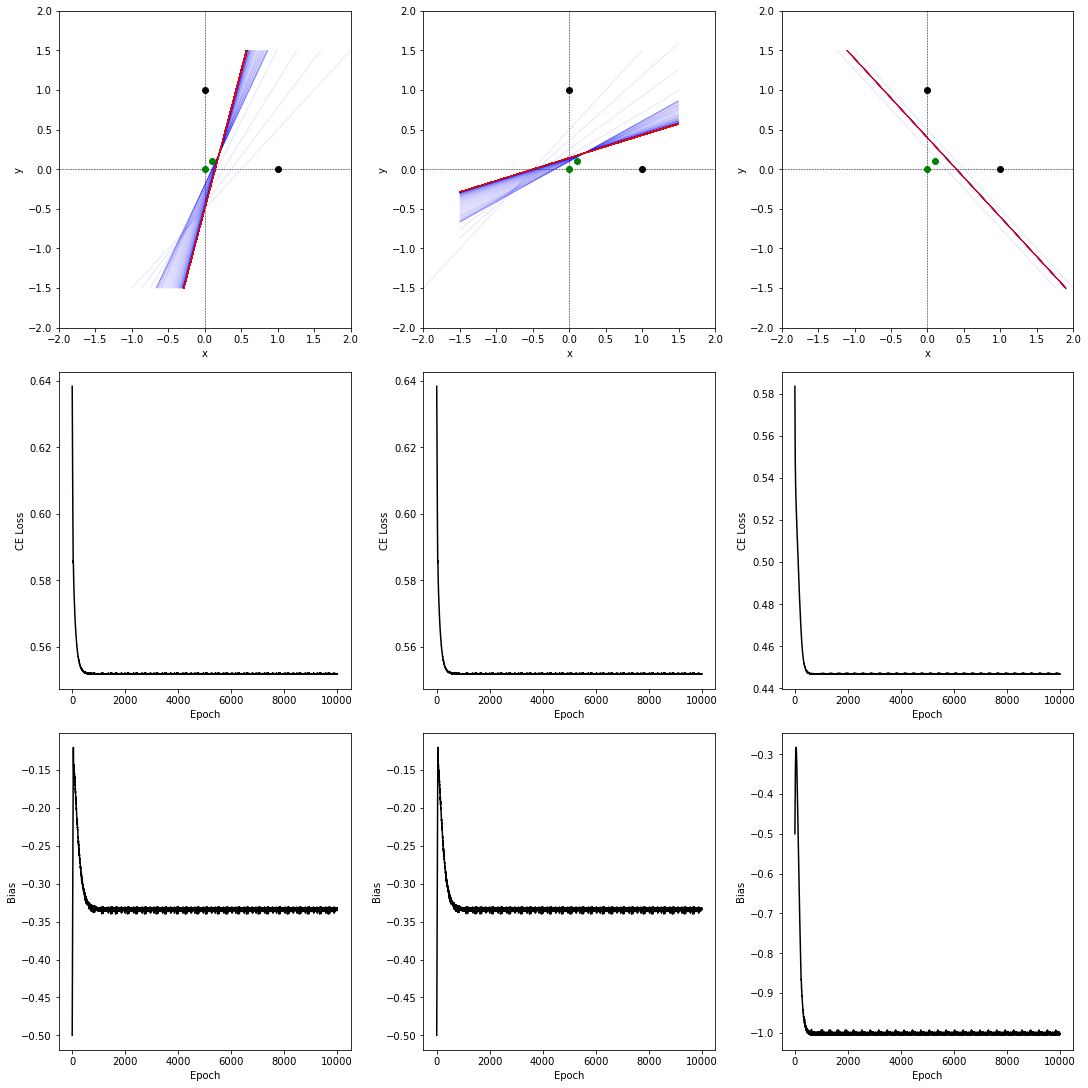

In [41]:
activationf = 'ReLU'
num_epochs = 10000
batch_size = 4
lr = 0.01

# linear color for plotting
max_v=1
t = num_epochs
step = 1. / t
RGBtriplet = []
for ii in range(t):
    red = ii * step
    green = 0
    blue = 1 - red
    RGBtriplet.append((red, green, blue))

# Custom weights 1
print('Custom weights 1')
custom_weight_1 = torch.from_numpy(np.array([[1, -1]])).float()
custom_bias_1 = torch.from_numpy(np.array([-0.5])).float()

train_loss_1, weight_list_1, bias_list_1 \
= train_the_model(transformed_dataset, custom_weight_1, custom_bias_1, activationf, num_epochs, batch_size, lr)
print('')


# Custom weights 2
print('Custom weights 2')
custom_weight_2 = torch.from_numpy(np.array([[-1, 1]])).float()
custom_bias_2 = torch.from_numpy(np.array([-0.5])).float()

train_loss_2, weight_list_2, bias_list_2 \
= train_the_model(transformed_dataset, custom_weight_2, custom_bias_2, activationf, num_epochs, batch_size, lr)
print('')


# Custom weights 3
print('Custom weights 3')
custom_weight_3 = torch.from_numpy(np.array([[1, 1]])).float()
custom_bias_3 = torch.from_numpy(np.array([-0.5])).float()

train_loss_3, weight_list_3, bias_list_3 \
= train_the_model(transformed_dataset, custom_weight_3, custom_bias_3, activationf, num_epochs, batch_size, lr)


fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs0 = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

ax = fig.add_subplot(gs0[0, 0])
ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
for ind in range(num_epochs):
    if ind % 10 == 0:
        (x1, x2), (y1, y2) = line_model(weight_list_1[ind], bias_list_1[ind])
        if ind == 0:
            alpha = 0.2
        else:
            alpha = 0.2
        ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha)
ax.plot([0], [0], c='g', marker='o')
ax.plot([0.1], [0.1], c='g', marker='o')
ax.plot([0], [1], c='k', marker='o')
ax.plot([1], [0], c='k', marker='o')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(gs0[0, 1])
ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
for ind in range(num_epochs):
    if ind % 10 == 0:
        (x1, x2), (y1, y2) = line_model(weight_list_2[ind], bias_list_2[ind])
        if ind == 0:
            alpha = 0.2
        else:
            alpha = 0.2
        ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha)
ax.plot([0], [0], c='g', marker='o')
ax.plot([0.1], [0.1], c='g', marker='o')
ax.plot([0], [1], c='k', marker='o')
ax.plot([1], [0], c='k', marker='o')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(gs0[0, 2])
ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
for ind in range(num_epochs):
    if ind % 100 == 0:
        (x1, x2), (y1, y2) = line_model(weight_list_3[ind], bias_list_3[ind])
        if ind == 0:
            alpha = 0.2
        else:
            alpha = 0.2
        ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha)
ax.plot([0], [0], c='g', marker='o')
ax.plot([0.1], [0.1], c='g', marker='o')
ax.plot([0], [1], c='k', marker='o')
ax.plot([1], [0], c='k', marker='o')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(gs0[1, 0])
ax.plot(train_loss_1, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('CE Loss')

ax = fig.add_subplot(gs0[1, 1])
ax.plot(train_loss_2, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('CE Loss')

ax = fig.add_subplot(gs0[1, 2])
ax.plot(train_loss_3, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('CE Loss')

ax = fig.add_subplot(gs0[2, 0])
ax.plot(bias_list_1, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('Bias')

ax = fig.add_subplot(gs0[2, 1])
ax.plot(bias_list_2, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('Bias')

ax = fig.add_subplot(gs0[2, 2])
ax.plot(bias_list_3, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('Bias')

plt.show()

filename = f'../results/convexity_relu_lr_{lr}.pdf'
fig.savefig(filename, bbox_inches='tight')


In [ ]:
weight_1 = np.linspace(-1, 3, 401)
weight_2 = np.linspace(-1, 3, 401)
bias = np.linspace(-2, 0, 201)

loss_res
for ii in range(len(sampling_vec_along)):
    parameters_in = parameters_in_both[0] + sampling_vec_along[ii] * parameters_in_both_diff
    loss_res = \
        hpfn.get_gradient_hessian(args, train_flow_snapshots_r, train_labels_snapshots_r, parameters_in)
    loss_res_along.append(loss_res)
    print(loss_res)

loss_list = get_loss(transformed_dataset, custom_weight, custom_bias, 
                     activationf, batch_size=4, negative_slope=0.02)





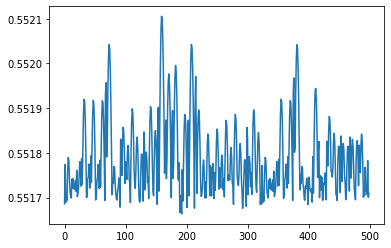

In [42]:
plt.plot(train_loss_1[-500:])
plt.show()

In [43]:
parameter_1 = np.array([weight_list_1[-1][0], weight_list_1[-1][1], bias_list_1[-1]])
parameter_2 = np.array([weight_list_2[-1][0], weight_list_2[-1][1], bias_list_2[-1]])
parameter_3 = np.array([weight_list_3[-1][0], weight_list_3[-1][1], bias_list_3[-1]])

print(parameter_1)
print(parameter_2)
print(parameter_3)

[ 2.3297462  -0.6641935  -0.33272803]
[-0.6641935   2.3297462  -0.33272803]
[ 2.5120718  2.5120718 -1.0022311]


In [50]:
activationf = 'ReLU'

parameters_diff_12 = parameter_1 - parameter_2
parameters_diff_23 = parameter_2 - parameter_3
parameters_diff_31 = parameter_3 - parameter_1

sampling_vec_along = np.linspace(-2, 3, 501)

loss_res_along_12 = []
for ii in range(len(sampling_vec_along)):
    parameters_in = parameter_2 + sampling_vec_along[ii] * parameters_diff_12
    custom_weight = torch.from_numpy(parameters_in[:2].reshape(1, 2)).float()
    custom_bias = torch.from_numpy(parameters_in[-1:]).float()
    loss_list = get_loss(transformed_dataset, custom_weight, custom_bias, activationf)
    loss_res_along_12.append(loss_list[0])
    
loss_res_along_23 = []
for ii in range(len(sampling_vec_along)):
    parameters_in = parameter_3 + sampling_vec_along[ii] * parameters_diff_23
    custom_weight = torch.from_numpy(parameters_in[:2].reshape(1, 2)).float()
    custom_bias = torch.from_numpy(parameters_in[-1:]).float()
    loss_list = get_loss(transformed_dataset, custom_weight, custom_bias, activationf)
    loss_res_along_23.append(loss_list[0])
    
loss_res_along_31 = []
for ii in range(len(sampling_vec_along)):
    parameters_in = parameter_1 + sampling_vec_along[ii] * parameters_diff_31
    custom_weight = torch.from_numpy(parameters_in[:2].reshape(1, 2)).float()
    custom_bias = torch.from_numpy(parameters_in[-1:]).float()
    loss_list = get_loss(transformed_dataset, custom_weight, custom_bias, activationf)
    loss_res_along_31.append(loss_list[0])



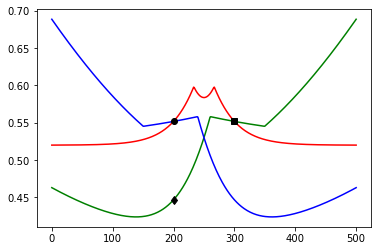

In [58]:
plt.plot(loss_res_along_12, 'r')
plt.plot(loss_res_along_23, 'g')
plt.plot(loss_res_along_31, 'b')
plt.plot(200, train_loss_1[-1], 'ko')
plt.plot(300, train_loss_2[-1], 'ks')
plt.plot(200, train_loss_3[-1], 'kd')
plt.show()

In [54]:
sampling_vec_along[300]

1.0

## LeakyReLU

Custom weights 1
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[ 1., -1.]], requires_grad=True)
Parameter containing:
tensor([[2.6098, 2.6098]], requires_grad=True)
Parameter containing:
tensor([-1.0406], requires_grad=True)

Custom weights 2
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[-1.,  1.]], requires_grad=True)
Parameter containing:
tensor([[2.6098, 2.6098]], requires_grad=True)
Parameter containing:
tensor([-1.0406], requires_grad=True)

Custom weights 3
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[1., 1.]], requires_grad=True)
Parameter containing:
tensor([[2.6095, 2.6095]], requires_grad=True)
Parameter containing:
tensor([-1.0404], requires_grad=True)


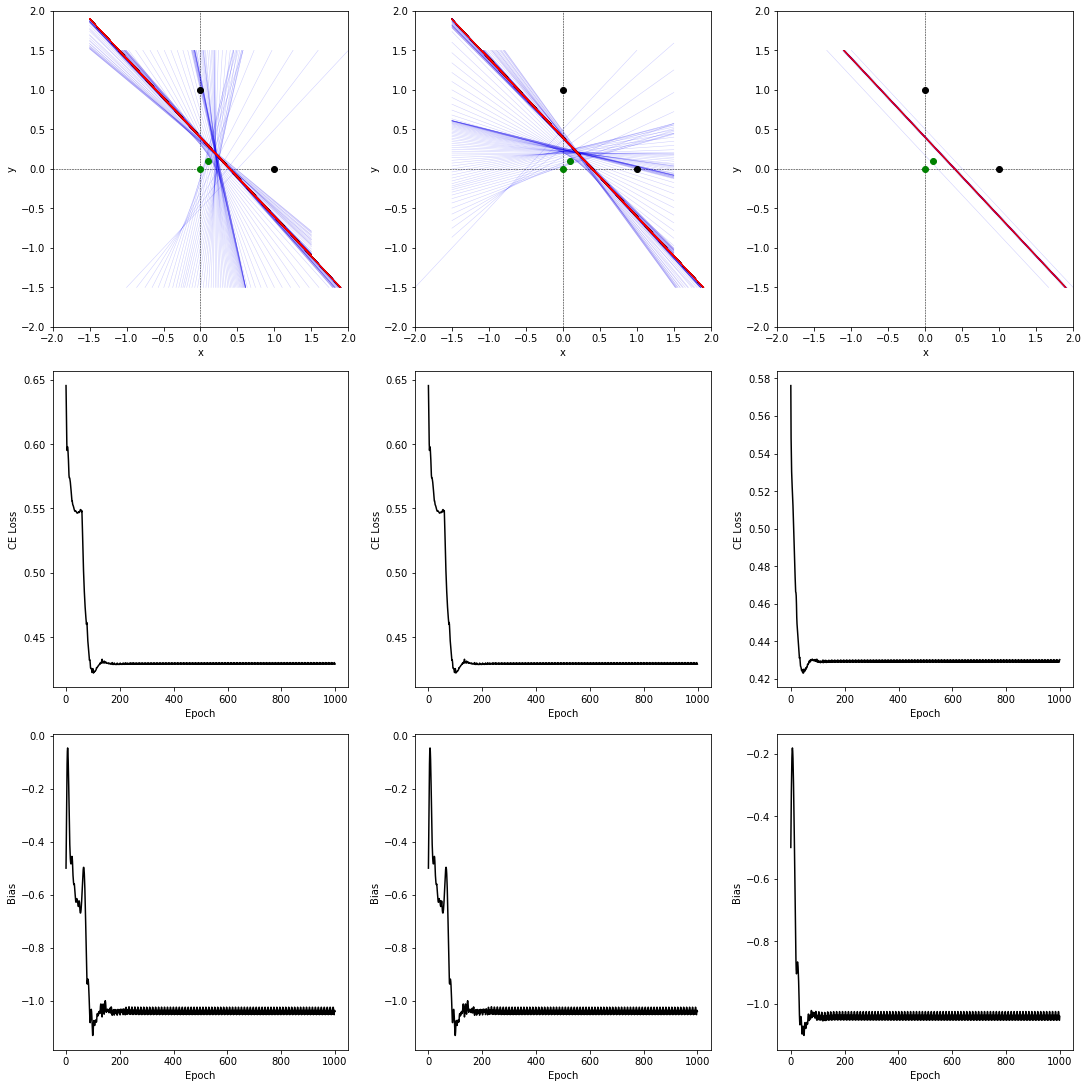

In [95]:
activationf = 'LeakyReLU'
num_epochs = 1000
batch_size = 4
lr = 0.1
negative_slope = 0.1

# Custom weights 1
print('Custom weights 1')
custom_weight_1 = torch.from_numpy(np.array([[1, -1]])).float()
custom_bias_1 = torch.from_numpy(np.array([-0.5])).float()

train_loss_1, weight_list_1, bias_list_1 \
= train_the_model(transformed_dataset, custom_weight_1, custom_bias_1, activationf, num_epochs, batch_size, lr, negative_slope)
print('')


# Custom weights 2
print('Custom weights 2')
custom_weight_2 = torch.from_numpy(np.array([[-1, 1]])).float()
custom_bias_2 = torch.from_numpy(np.array([-0.5])).float()

train_loss_2, weight_list_2, bias_list_2 \
= train_the_model(transformed_dataset, custom_weight_2, custom_bias_2, activationf, num_epochs, batch_size, lr, negative_slope)
print('')


# Custom weights 3
print('Custom weights 3')
custom_weight_3 = torch.from_numpy(np.array([[1, 1]])).float()
custom_bias_3 = torch.from_numpy(np.array([-0.5])).float()

train_loss_3, weight_list_3, bias_list_3 \
= train_the_model(transformed_dataset, custom_weight_3, custom_bias_3, activationf, num_epochs, batch_size, lr, negative_slope)


fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs0 = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

ax = fig.add_subplot(gs0[0, 0])
ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
for ind in range(num_epochs):
    if ind % 1 == 0:
        (x1, x2), (y1, y2) = line_model(weight_list_1[ind], bias_list_1[ind])
        if ind == 0:
            alpha = 0.2
        else:
            alpha = 0.2
        ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha)
ax.plot([0], [0], c='g', marker='o')
ax.plot([0.1], [0.1], c='g', marker='o')
ax.plot([0], [1], c='k', marker='o')
ax.plot([1], [0], c='k', marker='o')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(gs0[0, 1])
ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
for ind in range(num_epochs):
    if ind % 1 == 0:
        (x1, x2), (y1, y2) = line_model(weight_list_2[ind], bias_list_2[ind])
        if ind == 0:
            alpha = 0.2
        else:
            alpha = 0.2
        ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha)
ax.plot([0], [0], c='g', marker='o')
ax.plot([0.1], [0.1], c='g', marker='o')
ax.plot([0], [1], c='k', marker='o')
ax.plot([1], [0], c='k', marker='o')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(gs0[0, 2])
ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
for ind in range(num_epochs):
    if ind % 10 == 0:
        (x1, x2), (y1, y2) = line_model(weight_list_3[ind], bias_list_3[ind])
        if ind == 0:
            alpha = 0.2
        else:
            alpha = 0.2
        ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha)
ax.plot([0], [0], c='g', marker='o')
ax.plot([0.1], [0.1], c='g', marker='o')
ax.plot([0], [1], c='k', marker='o')
ax.plot([1], [0], c='k', marker='o')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(gs0[1, 0])
ax.plot(train_loss_1, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('CE Loss')

ax = fig.add_subplot(gs0[1, 1])
ax.plot(train_loss_2, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('CE Loss')

ax = fig.add_subplot(gs0[1, 2])
ax.plot(train_loss_3, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('CE Loss')

ax = fig.add_subplot(gs0[2, 0])
ax.plot(bias_list_1, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('Bias')

ax = fig.add_subplot(gs0[2, 1])
ax.plot(bias_list_2, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('Bias')

ax = fig.add_subplot(gs0[2, 2])
ax.plot(bias_list_3, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('Bias')

plt.show()

filename = f'../results/convexity_leakyrelu_negative_slope_{negative_slope}_lr_{lr}.pdf'
fig.savefig(filename, bbox_inches='tight')

Custom weights 1
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[ 1., -1.]], requires_grad=True)
Parameter containing:
tensor([[2.3960, 2.3957]], requires_grad=True)
Parameter containing:
tensor([-1.0107], requires_grad=True)

Custom weights 2
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[-1.,  1.]], requires_grad=True)
Parameter containing:
tensor([[2.3957, 2.3960]], requires_grad=True)
Parameter containing:
tensor([-1.0107], requires_grad=True)

Custom weights 3
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[1., 1.]], requires_grad=True)
Parameter containing:
tensor([[2.6088, 2.6088]], requires_grad=True)
Parameter containing:
tensor([-0.7712], requires_grad=True)
Custom weights 1
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Paramete

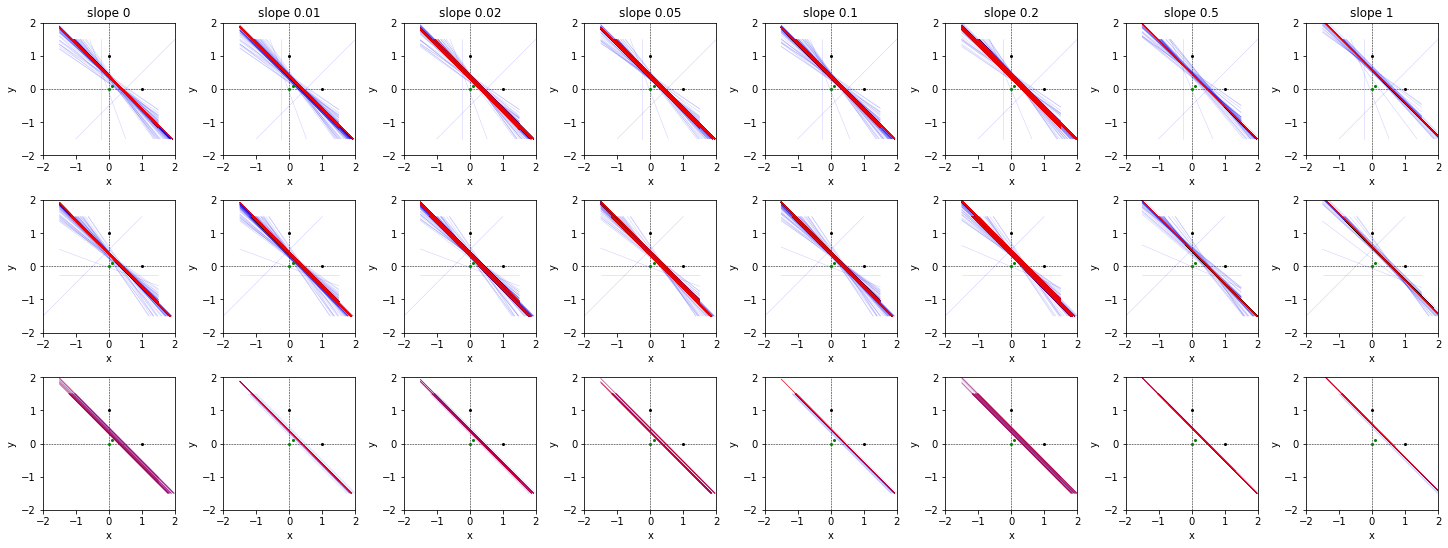

In [100]:
# Vary the slope

activationf = 'LeakyReLU'
num_epochs = 1000
batch_size = 4
lr = 1
negative_slope_list = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

fig = plt.figure(figsize = (20, 7.5), constrained_layout=True)
gs0 = gridspec.GridSpec(ncols=8, nrows=3, figure=fig)

for ind0, negative_slope in enumerate(negative_slope_list):

    # Custom weights 1
    print('Custom weights 1')
    custom_weight_1 = torch.from_numpy(np.array([[1, -1]])).float()
    custom_bias_1 = torch.from_numpy(np.array([-0.5])).float()

    train_loss_1, weight_list_1, bias_list_1 \
    = train_the_model(transformed_dataset, custom_weight_1, custom_bias_1, activationf, num_epochs, batch_size, lr, negative_slope)
    print('')


    # Custom weights 2
    print('Custom weights 2')
    custom_weight_2 = torch.from_numpy(np.array([[-1, 1]])).float()
    custom_bias_2 = torch.from_numpy(np.array([-0.5])).float()

    train_loss_2, weight_list_2, bias_list_2 \
    = train_the_model(transformed_dataset, custom_weight_2, custom_bias_2, activationf, num_epochs, batch_size, lr, negative_slope)
    print('')


    # Custom weights 3
    print('Custom weights 3')
    custom_weight_3 = torch.from_numpy(np.array([[1, 1]])).float()
    custom_bias_3 = torch.from_numpy(np.array([-0.5])).float()

    train_loss_3, weight_list_3, bias_list_3 \
    = train_the_model(transformed_dataset, custom_weight_3, custom_bias_3, activationf, num_epochs, batch_size, lr, negative_slope)


    ax = fig.add_subplot(gs0[0, ind0])
    ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
    ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
    for ind in range(num_epochs):
        if ind % 1 == 0:
            (x1, x2), (y1, y2) = line_model(weight_list_1[ind], bias_list_1[ind])
            if ind == 0:
                alpha = 0.2
            else:
                alpha = 0.2
            ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha)
    ax.plot([0], [0], c='g', marker='o', markersize=2)
    ax.plot([0.1], [0.1], c='g', marker='o', markersize=2)
    ax.plot([0], [1], c='k', marker='o', markersize=2)
    ax.plot([1], [0], c='k', marker='o', markersize=2)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'slope {negative_slope}')

    ax = fig.add_subplot(gs0[1, ind0])
    ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
    ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
    for ind in range(num_epochs):
        if ind % 1 == 0:
            (x1, x2), (y1, y2) = line_model(weight_list_2[ind], bias_list_2[ind])
            if ind == 0:
                alpha = 0.2
            else:
                alpha = 0.2
            ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha)
    ax.plot([0], [0], c='g', marker='o', markersize=2)
    ax.plot([0.1], [0.1], c='g', marker='o', markersize=2)
    ax.plot([0], [1], c='k', marker='o', markersize=2)
    ax.plot([1], [0], c='k', marker='o', markersize=2)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax = fig.add_subplot(gs0[2, ind0])
    ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
    ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
    for ind in range(num_epochs):
        if ind % 10 == 0:
            (x1, x2), (y1, y2) = line_model(weight_list_3[ind], bias_list_3[ind])
            if ind == 0:
                alpha = 0.2
            else:
                alpha = 0.2
            ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha)
    ax.plot([0], [0], c='g', marker='o', markersize=2)
    ax.plot([0.1], [0.1], c='g', marker='o', markersize=2)
    ax.plot([0], [1], c='k', marker='o', markersize=2)
    ax.plot([1], [0], c='k', marker='o', markersize=2)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.show()

filename = f'../results/convexity_leakyrelu_compare_lr_{lr}.pdf'
fig.savefig(filename, bbox_inches='tight')

Custom weights 1
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[ 1., -1.]], requires_grad=True)
Parameter containing:
tensor([[2.3960, 2.3957]], requires_grad=True)
Parameter containing:
tensor([-1.0107], requires_grad=True)

Custom weights 2
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[-1.,  1.]], requires_grad=True)
Parameter containing:
tensor([[2.3957, 2.3960]], requires_grad=True)
Parameter containing:
tensor([-1.0107], requires_grad=True)

Custom weights 3
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[1., 1.]], requires_grad=True)
Parameter containing:
tensor([[2.6088, 2.6088]], requires_grad=True)
Parameter containing:
tensor([-0.7712], requires_grad=True)
Custom weights 1
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Paramete

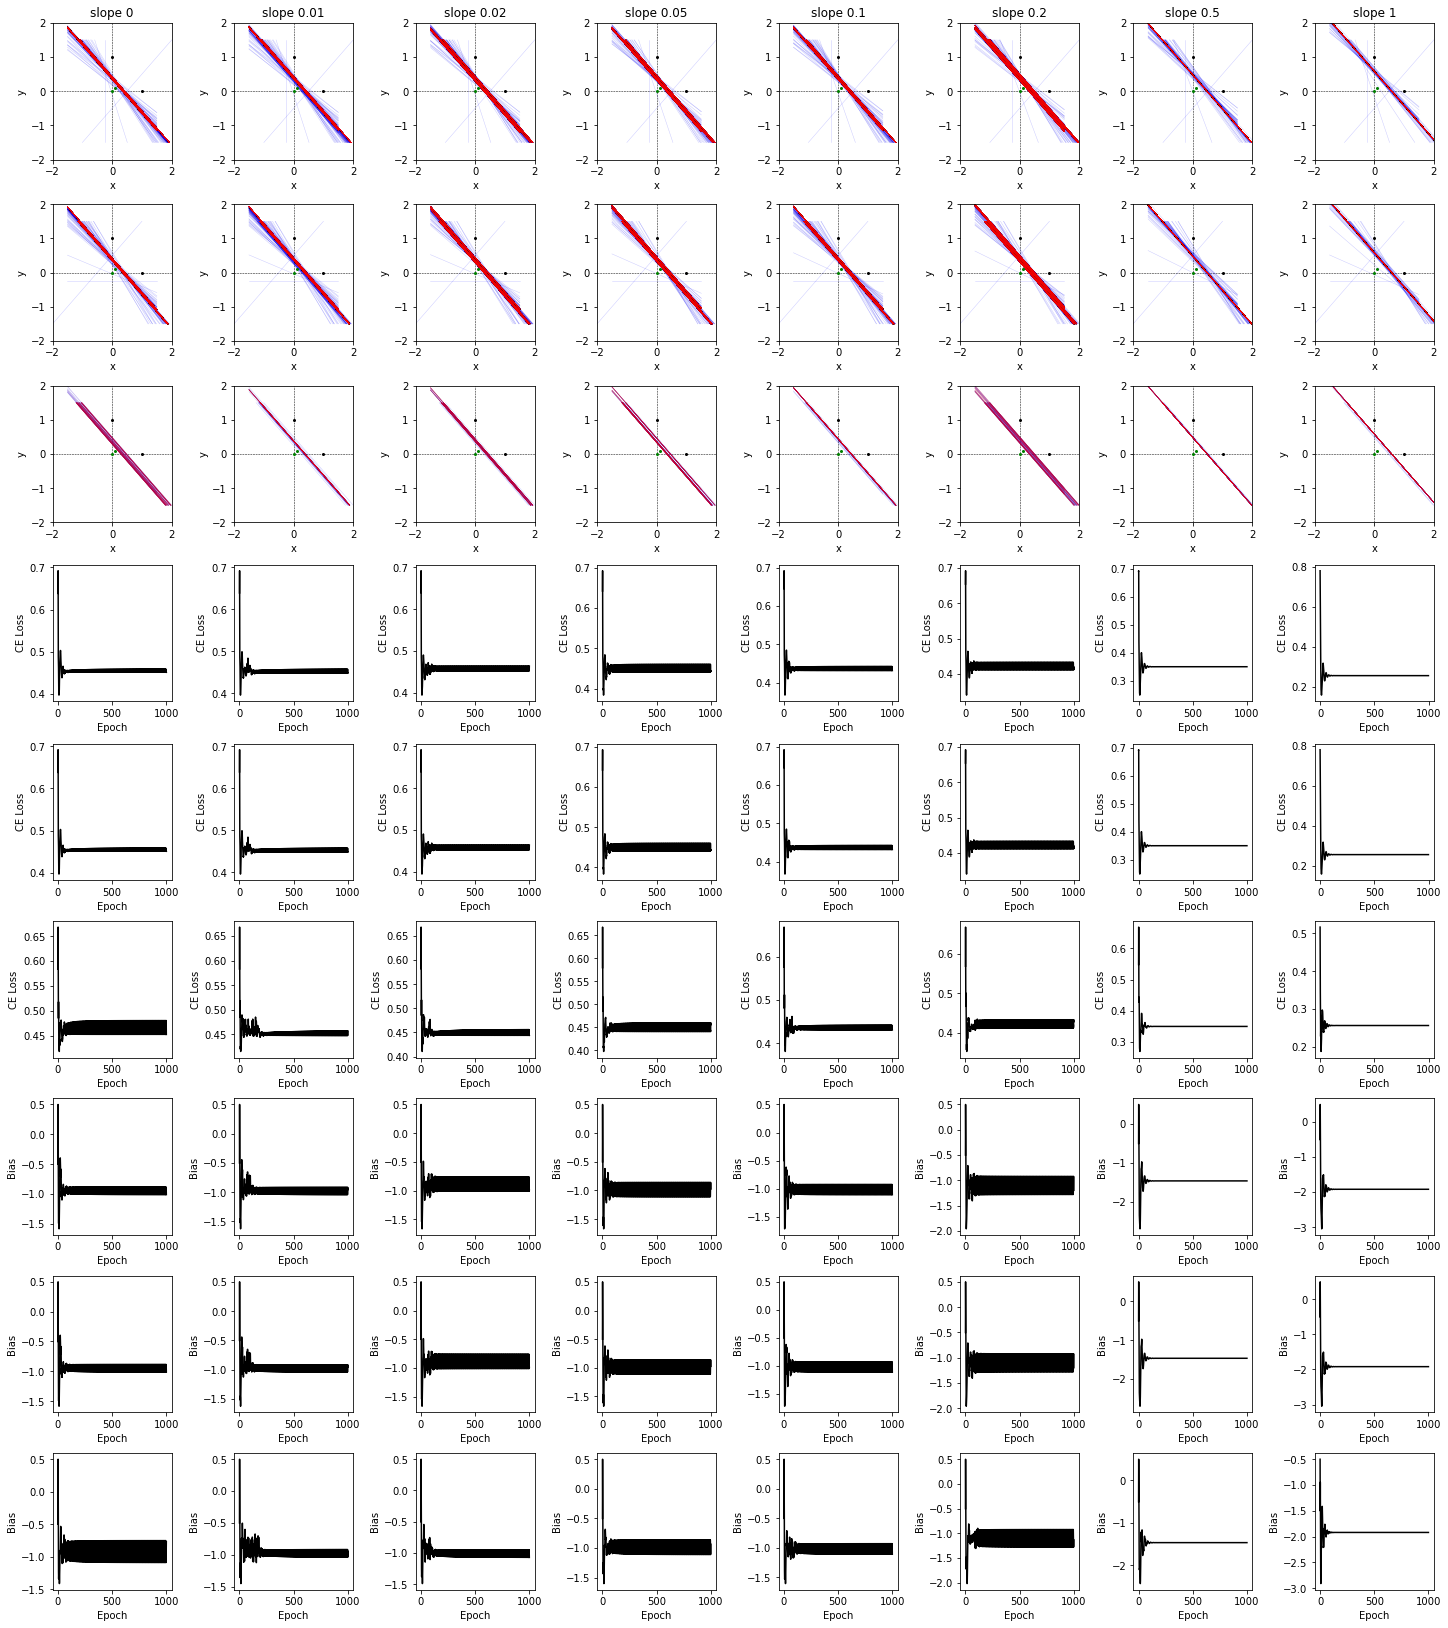

In [99]:
# Vary the slope

activationf = 'LeakyReLU'
num_epochs = 1000
batch_size = 4
lr = 1
negative_slope_list = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

fig = plt.figure(figsize = (20, 22.5), constrained_layout=True)
gs0 = gridspec.GridSpec(ncols=8, nrows=9, figure=fig)

for ind0, negative_slope in enumerate(negative_slope_list):

    # Custom weights 1
    print('Custom weights 1')
    custom_weight_1 = torch.from_numpy(np.array([[1, -1]])).float()
    custom_bias_1 = torch.from_numpy(np.array([-0.5])).float()

    train_loss_1, weight_list_1, bias_list_1 \
    = train_the_model(transformed_dataset, custom_weight_1, custom_bias_1, activationf, num_epochs, batch_size, lr, negative_slope)
    print('')


    # Custom weights 2
    print('Custom weights 2')
    custom_weight_2 = torch.from_numpy(np.array([[-1, 1]])).float()
    custom_bias_2 = torch.from_numpy(np.array([-0.5])).float()

    train_loss_2, weight_list_2, bias_list_2 \
    = train_the_model(transformed_dataset, custom_weight_2, custom_bias_2, activationf, num_epochs, batch_size, lr, negative_slope)
    print('')


    # Custom weights 3
    print('Custom weights 3')
    custom_weight_3 = torch.from_numpy(np.array([[1, 1]])).float()
    custom_bias_3 = torch.from_numpy(np.array([-0.5])).float()

    train_loss_3, weight_list_3, bias_list_3 \
    = train_the_model(transformed_dataset, custom_weight_3, custom_bias_3, activationf, num_epochs, batch_size, lr, negative_slope)


    ax = fig.add_subplot(gs0[0, ind0])
    ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
    ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
    for ind in range(num_epochs):
        if ind % 1 == 0:
            (x1, x2), (y1, y2) = line_model(weight_list_1[ind], bias_list_1[ind])
            if ind == 0:
                alpha = 0.2
            else:
                alpha = 0.2
            ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha)
    ax.plot([0], [0], c='g', marker='o', markersize=2)
    ax.plot([0.1], [0.1], c='g', marker='o', markersize=2)
    ax.plot([0], [1], c='k', marker='o', markersize=2)
    ax.plot([1], [0], c='k', marker='o', markersize=2)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'slope {negative_slope}')

    ax = fig.add_subplot(gs0[1, ind0])
    ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
    ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
    for ind in range(num_epochs):
        if ind % 1 == 0:
            (x1, x2), (y1, y2) = line_model(weight_list_2[ind], bias_list_2[ind])
            if ind == 0:
                alpha = 0.2
            else:
                alpha = 0.2
            ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha)
    ax.plot([0], [0], c='g', marker='o', markersize=2)
    ax.plot([0.1], [0.1], c='g', marker='o', markersize=2)
    ax.plot([0], [1], c='k', marker='o', markersize=2)
    ax.plot([1], [0], c='k', marker='o', markersize=2)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax = fig.add_subplot(gs0[2, ind0])
    ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
    ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
    for ind in range(num_epochs):
        if ind % 10 == 0:
            (x1, x2), (y1, y2) = line_model(weight_list_3[ind], bias_list_3[ind])
            if ind == 0:
                alpha = 0.2
            else:
                alpha = 0.2
            ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha)
    ax.plot([0], [0], c='g', marker='o', markersize=2)
    ax.plot([0.1], [0.1], c='g', marker='o', markersize=2)
    ax.plot([0], [1], c='k', marker='o', markersize=2)
    ax.plot([1], [0], c='k', marker='o', markersize=2)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    ax = fig.add_subplot(gs0[3, ind0])
    ax.plot(train_loss_1, 'k')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('CE Loss')

    ax = fig.add_subplot(gs0[4, ind0])
    ax.plot(train_loss_2, 'k')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('CE Loss')

    ax = fig.add_subplot(gs0[5, ind0])
    ax.plot(train_loss_3, 'k')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('CE Loss')

    ax = fig.add_subplot(gs0[6, ind0])
    ax.plot(bias_list_1, 'k')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Bias')

    ax = fig.add_subplot(gs0[7, ind0])
    ax.plot(bias_list_2, 'k')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Bias')

    ax = fig.add_subplot(gs0[8, ind0])
    ax.plot(bias_list_3, 'k')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Bias')

plt.show()

filename = f'../results/convexity_leakyrelu_compare_full_lr_{lr}.pdf'
fig.savefig(filename, bbox_inches='tight')

## Linear

Custom weights 1
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[ 1., -1.]], requires_grad=True)
Parameter containing:
tensor([[3.2540, 3.2024]], requires_grad=True)
Parameter containing:
tensor([-1.8811], requires_grad=True)

Custom weights 2
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[-1.,  1.]], requires_grad=True)
Parameter containing:
tensor([[3.2024, 3.2540]], requires_grad=True)
Parameter containing:
tensor([-1.8811], requires_grad=True)

Custom weights 3
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[1., 1.]], requires_grad=True)
Parameter containing:
tensor([[3.2911, 3.2911]], requires_grad=True)
Parameter containing:
tensor([-1.9196], requires_grad=True)


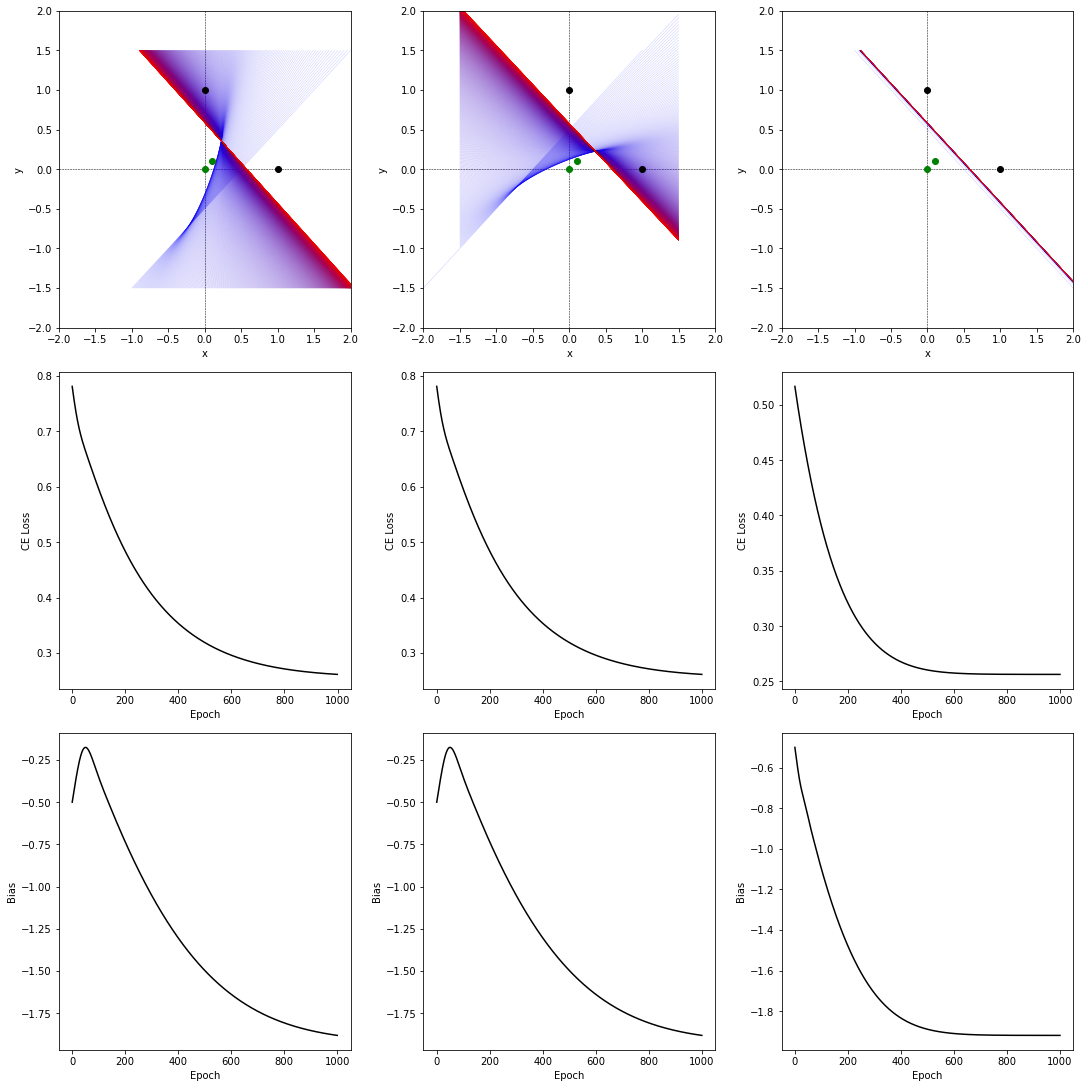

In [97]:
activationf = 'Linear'
num_epochs = 1000
batch_size = 4
lr = 0.01

# Custom weights 1
print('Custom weights 1')
custom_weight_1 = torch.from_numpy(np.array([[1, -1]])).float()
custom_bias_1 = torch.from_numpy(np.array([-0.5])).float()

train_loss_1, weight_list_1, bias_list_1 \
= train_the_model(transformed_dataset, custom_weight_1, custom_bias_1, activationf, num_epochs, batch_size, lr)
print('')


# Custom weights 2
print('Custom weights 2')
custom_weight_2 = torch.from_numpy(np.array([[-1, 1]])).float()
custom_bias_2 = torch.from_numpy(np.array([-0.5])).float()

train_loss_2, weight_list_2, bias_list_2 \
= train_the_model(transformed_dataset, custom_weight_2, custom_bias_2, activationf, num_epochs, batch_size, lr)
print('')


# Custom weights 3
print('Custom weights 3')
custom_weight_3 = torch.from_numpy(np.array([[1, 1]])).float()
custom_bias_3 = torch.from_numpy(np.array([-0.5])).float()

train_loss_3, weight_list_3, bias_list_3 \
= train_the_model(transformed_dataset, custom_weight_3, custom_bias_3, activationf, num_epochs, batch_size, lr)


fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs0 = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

ax = fig.add_subplot(gs0[0, 0])
ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
for ind in range(num_epochs):
    if ind % 1 == 0:
        (x1, x2), (y1, y2) = line_model(weight_list_1[ind], bias_list_1[ind])
        if ind == 0:
            alpha = 0.2
        else:
            alpha = 0.2
        ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha) 
ax.plot([0], [0], c='g', marker='o')
ax.plot([0.1], [0.1], c='g', marker='o')
ax.plot([0], [1], c='k', marker='o')
ax.plot([1], [0], c='k', marker='o')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(gs0[0, 1])
ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
for ind in range(num_epochs):
    if ind % 1 == 0:
        (x1, x2), (y1, y2) = line_model(weight_list_2[ind], bias_list_2[ind])
        if ind == 0:
            alpha = 0.2
        else:
            alpha = 0.2
        ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha)
ax.plot([0], [0], c='g', marker='o')
ax.plot([0.1], [0.1], c='g', marker='o')
ax.plot([0], [1], c='k', marker='o')
ax.plot([1], [0], c='k', marker='o')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(gs0[0, 2])
ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
for ind in range(num_epochs):
    if ind % 10 == 0:
        (x1, x2), (y1, y2) = line_model(weight_list_3[ind], bias_list_3[ind])
        if ind == 0:
            alpha = 0.2
        else:
            alpha = 0.2
        ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha)
ax.plot([0], [0], c='g', marker='o')
ax.plot([0.1], [0.1], c='g', marker='o')
ax.plot([0], [1], c='k', marker='o')
ax.plot([1], [0], c='k', marker='o')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(gs0[1, 0])
ax.plot(train_loss_1, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('CE Loss')

ax = fig.add_subplot(gs0[1, 1])
ax.plot(train_loss_2, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('CE Loss')

ax = fig.add_subplot(gs0[1, 2])
ax.plot(train_loss_3, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('CE Loss')

ax = fig.add_subplot(gs0[2, 0])
ax.plot(bias_list_1, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('Bias')

ax = fig.add_subplot(gs0[2, 1])
ax.plot(bias_list_2, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('Bias')

ax = fig.add_subplot(gs0[2, 2])
ax.plot(bias_list_3, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('Bias')

plt.show()

filename = f'../results/convexity_linear_lr_{lr}.pdf'
fig.savefig(filename, bbox_inches='tight')

## ELU

Custom weights 1
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[ 1., -1.]], requires_grad=True)
Parameter containing:
tensor([[2.8855, 2.8846]], requires_grad=True)
Parameter containing:
tensor([-1.4023], requires_grad=True)

Custom weights 2
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[-1.,  1.]], requires_grad=True)
Parameter containing:
tensor([[2.8846, 2.8855]], requires_grad=True)
Parameter containing:
tensor([-1.4023], requires_grad=True)

Custom weights 3
Reset trainable parameters of layer = Linear(in_features=2, out_features=1, bias=True)
Parameter containing:
tensor([[1., 1.]], requires_grad=True)
Parameter containing:
tensor([[2.8864, 2.8864]], requires_grad=True)
Parameter containing:
tensor([-1.4030], requires_grad=True)


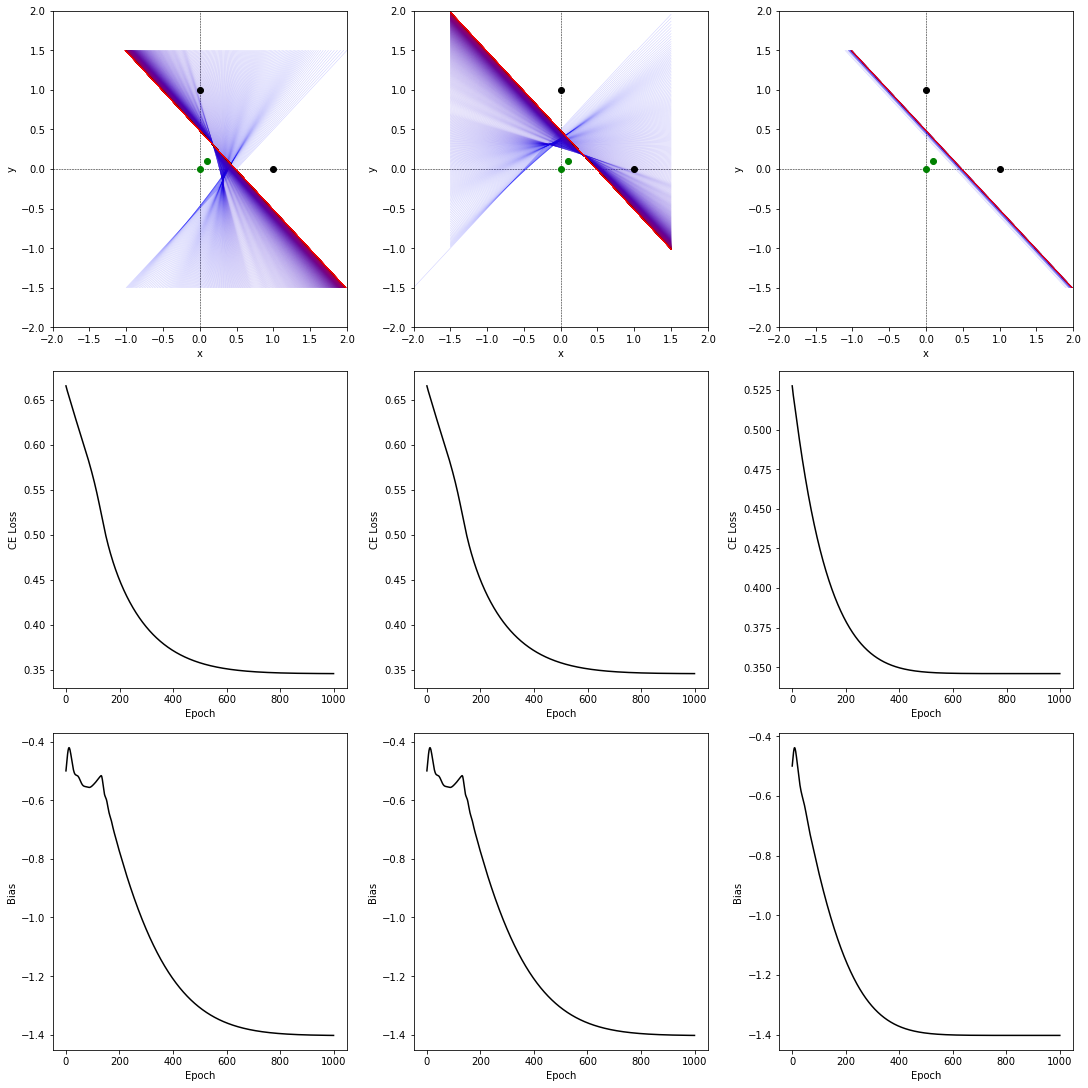

In [98]:
activationf = 'ELU'
num_epochs = 1000
batch_size = 4
lr = 0.01

# Custom weights 1
print('Custom weights 1')
custom_weight_1 = torch.from_numpy(np.array([[1, -1]])).float()
custom_bias_1 = torch.from_numpy(np.array([-0.5])).float()

train_loss_1, weight_list_1, bias_list_1 \
= train_the_model(transformed_dataset, custom_weight_1, custom_bias_1, activationf, num_epochs, batch_size, lr)
print('')


# Custom weights 2
print('Custom weights 2')
custom_weight_2 = torch.from_numpy(np.array([[-1, 1]])).float()
custom_bias_2 = torch.from_numpy(np.array([-0.5])).float()

train_loss_2, weight_list_2, bias_list_2 \
= train_the_model(transformed_dataset, custom_weight_2, custom_bias_2, activationf, num_epochs, batch_size, lr)
print('')


# Custom weights 3
print('Custom weights 3')
custom_weight_3 = torch.from_numpy(np.array([[1, 1]])).float()
custom_bias_3 = torch.from_numpy(np.array([-0.5])).float()

train_loss_3, weight_list_3, bias_list_3 \
= train_the_model(transformed_dataset, custom_weight_3, custom_bias_3, activationf, num_epochs, batch_size, lr)


fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs0 = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

ax = fig.add_subplot(gs0[0, 0])
ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
for ind in range(num_epochs):
    if ind % 1 == 0:
        (x1, x2), (y1, y2) = line_model(weight_list_1[ind], bias_list_1[ind])
        if ind == 0:
            alpha = 0.2
        else:
            alpha = 0.2
        ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha) 
ax.plot([0], [0], c='g', marker='o')
ax.plot([0.1], [0.1], c='g', marker='o')
ax.plot([0], [1], c='k', marker='o')
ax.plot([1], [0], c='k', marker='o')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(gs0[0, 1])
ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
for ind in range(num_epochs):
    if ind % 1 == 0:
        (x1, x2), (y1, y2) = line_model(weight_list_2[ind], bias_list_2[ind])
        if ind == 0:
            alpha = 0.2
        else:
            alpha = 0.2
        ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha) 
ax.plot([0], [0], c='g', marker='o')
ax.plot([0.1], [0.1], c='g', marker='o')
ax.plot([0], [1], c='k', marker='o')
ax.plot([1], [0], c='k', marker='o')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(gs0[0, 2])
ax.plot((-2, 2), (0, 0), c='k', linewidth=0.5, linestyle='--')
ax.plot((0, 0), (-2, 2), c='k', linewidth=0.5, linestyle='--')
for ind in range(num_epochs):
    if ind % 10 == 0:
        (x1, x2), (y1, y2) = line_model(weight_list_3[ind], bias_list_3[ind])
        if ind == 0:
            alpha = 0.2
        else:
            alpha = 0.2
        ax.plot((x1, x2), (y1, y2), c=RGBtriplet[ind], linewidth=0.5, alpha=alpha)
ax.plot([0], [0], c='g', marker='o')
ax.plot([0.1], [0.1], c='g', marker='o')
ax.plot([0], [1], c='k', marker='o')
ax.plot([1], [0], c='k', marker='o')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(gs0[1, 0])
ax.plot(train_loss_1, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('CE Loss')

ax = fig.add_subplot(gs0[1, 1])
ax.plot(train_loss_2, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('CE Loss')

ax = fig.add_subplot(gs0[1, 2])
ax.plot(train_loss_3, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('CE Loss')

ax = fig.add_subplot(gs0[2, 0])
ax.plot(bias_list_1, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('Bias')

ax = fig.add_subplot(gs0[2, 1])
ax.plot(bias_list_2, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('Bias')

ax = fig.add_subplot(gs0[2, 2])
ax.plot(bias_list_3, 'k')
ax.set_xlabel('Epoch')
ax.set_ylabel('Bias')

plt.show()

filename = f'../results/convexity_elu_{lr}.pdf'
fig.savefig(filename, bbox_inches='tight')